# **Hybrid Modelling of Humint Source Performance: ML-TSSP Model**

## **1. Machine Learning Section(data preparation, training, testing and evaluation)**

In [9]:
#necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor,XGBClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,mean_absolute_error,mean_squared_error,r2_score,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
import os
import warnings


In [10]:
%matplotlib inline

**i) Synthetic Data Generation**

In [11]:
#Synthetic data generation

np.random.seed(42)

rows = 15000

data = {
    "source_id": [f"SRC_{i:05d}" for i in range(1, rows + 1)],
    "task_success_rate": np.round(np.random.uniform(0.3, 0.98, rows), 3),
    "corroboration_score": np.round(np.random.uniform(0.2, 0.95, rows), 3),
    "report_timeliness": np.round(np.random.uniform(0.4, 1.0, rows), 3),
    "handler_confidence": np.round(np.random.uniform(0.3, 0.99, rows), 3),
    "deception_score": np.round(np.random.uniform(0.0, 0.8, rows), 3),
    "ci_flag": np.random.choice([0, 1], size=rows, p=[0.88, 0.12]),
}

df = pd.DataFrame(data)

# Reliability score
df["reliability_score"] = np.round(
    (
        0.30 * df["task_success_rate"]
        + 0.25 * df["corroboration_score"]
        + 0.20 * df["report_timeliness"]
        + 0.15 * df["handler_confidence"]
        - 0.15 * df["deception_score"]
        - 0.10 * df["ci_flag"]
    ),
    3,
)

# Behavior class logic (four-class)
df["behavior_class"] = np.where(
    (df["reliability_score"] >= 0.75) & (df["deception_score"] <= 0.25) & (df["ci_flag"] == 0),
    "cooperative",
    np.where(
        (df["deception_score"] > 0.55) | (df["ci_flag"] == 1),
        "deceptive",
        np.where(
            (df["reliability_score"] < 0.55) & (df["deception_score"] > 0.35),
            "coerced",
            "uncertain",
        ),
    ),
)

# Scenario probability
df["scenario_probability"] = np.round(
    np.clip(
        df["reliability_score"]
        - 0.25 * df["deception_score"]
        + np.random.normal(0, 0.05, rows),
        0,
        1,
    ),
    3,
)

# Save to CSV
file_path = Path("humint_source_dataset_15000_final.csv")
df.to_csv(file_path, index=False)

print("Saved to:", file_path.resolve())

Saved to: C:\Users\hp\OneDrive\Dokumenter\MSC. DSA\Intell Sources\humint_source_dataset_15000_final.csv


**ii) Behavior_class interpretation**
- cooperative reflects high reliability with low deception and no CI risk
- deceptive captures high deception indicators or CI flags
- coerced reflects low reliability with elevated deception but without explicit CI control
- uncertain covers mixed or ambiguous cases

In [12]:
df=pd.read_csv('humint_source_dataset_15000_final.csv')
df.head(25)

source_id  task_success_rate  corroboration_score  report_timeliness  \
0   SRC_00001              0.555                0.575              0.783   
1   SRC_00002              0.946                0.760              0.676   
2   SRC_00003              0.798                0.622              0.979   
3   SRC_00004              0.707                0.262              0.531   
4   SRC_00005              0.406                0.339              0.753   
5   SRC_00006              0.406                0.364              0.820   
6   SRC_00007              0.339                0.393              0.895   
7   SRC_00008              0.889                0.624              0.644   
8   SRC_00009              0.709                0.578              0.812   
9   SRC_00010              0.781                0.352              0.582   
10  SRC_00011              0.314                0.251              0.661   
11  SRC_00012              0.960                0.329              0.937   
12  SRC_00013              0.866                0.938              0.970   
13  SRC_00014              0.444                0.551              0.831   
14  SRC_00015              0.424                0.851              0.625   
15  SRC_00016              0.425                0.837              0.892   
16  SRC_00017              0.507                0.584              0.416   
17  SRC_00018              0.657                0.730              0.462   
18  SRC_00019              0.594                0.345              0.797   
19  SRC_00020              0.498                0.716              0.575   
20  SRC_00021              0.716                0.404              0.971   
21  SRC_00022              0.395                0.824              0.662   
22  SRC_00023              0.499                0.263              0.658   
23  SRC_00024              0.549                0.780              0.807   
24  SRC_00025              0.610                0.275              0.861   

    handler_confidence  deception_score  ci_flag  reliability_score  \
0                0.528            0.593        0              0.457   
1                0.864            0.705        1              0.533   
2                0.986            0.371        0              0.683   
3                0.880            0.231        0              0.481   
4                0.539            0.255        1              0.300   
5                0.791            0.558        0              0.412   
6                0.668            0.454        0              0.411   
7                0.843            0.389        0              0.620   
8                0.406            0.162        1              0.456   
9                0.740            0.700        0              0.445   
10               0.834            0.625        0              0.320   
11               0.825            0.113        0              0.664   
12               0.965            0.294        0              0.789   
13               0.340            0.434        0              0.423   
14               0.539            0.363        0              0.491   
15               0.629            0.318        0              0.562   
16               0.514            0.575        0              0.372   
17               0.514            0.044        0              0.542   
18               0.422            0.377        0              0.431   
19               0.861            0.210        1              0.441   
20               0.927            0.068        0              0.639   
21               0.357            0.372        0              0.455   
22               0.407            0.137        0              0.388   
23               0.458            0.207        1              0.459   
24               0.651            0.406        0              0.461   

   behavior_class  scenario_probability  
0       deceptive                 0.243  
1       deceptive                 0.327  
2       uncertain                 0.601  
3       unce

In [13]:
df.dtypes, df.shape, df.isnull().sum(), df.describe(), df['behavior_class'].value_counts(),df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   source_id             15000 non-null  object 
 1   task_success_rate     15000 non-null  float64
 2   corroboration_score   15000 non-null  float64
 3   report_timeliness     15000 non-null  float64
 4   handler_confidence    15000 non-null  float64
 5   deception_score       15000 non-null  float64
 6   ci_flag               15000 non-null  int64  
 7   reliability_score     15000 non-null  float64
 8   behavior_class        15000 non-null  object 
 9   scenario_probability  15000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 1.1+ MB


(source_id                object
 task_success_rate       float64
 corroboration_score     float64
 report_timeliness       float64
 handler_confidence      float64
 deception_score         float64
 ci_flag                   int64
 reliability_score       float64
 behavior_class           object
 scenario_probability    float64
 dtype: object,
 (15000, 10),
 source_id               0
 task_success_rate       0
 corroboration_score     0
 report_timeliness       0
 handler_confidence      0
 deception_score         0
 ci_flag                 0
 reliability_score       0
 behavior_class          0
 scenario_probability    0
 dtype: int64,
        task_success_rate  corroboration_score  report_timeliness  \
 count       15000.000000         15000.000000       15000.000000   
 mean            0.637660             0.576945           0.699178   
 std             0.196309             0.215348           0.173455   
 min             0.300000             0.200000           0.400000   
 25%      

In [14]:
#view numerical columns
df.describe()

task_success_rate  corroboration_score  report_timeliness  \
count       15000.000000         15000.000000       15000.000000   
mean            0.637660             0.576945           0.699178   
std             0.196309             0.215348           0.173455   
min             0.300000             0.200000           0.400000   
25%             0.468000             0.393000           0.548000   
50%             0.636000             0.579000           0.698000   
75%             0.809000             0.760000           0.849000   
max             0.980000             0.950000           1.000000   

       handler_confidence  deception_score       ci_flag  reliability_score  \
count        15000.000000     15000.000000  15000.000000       15000.000000   
mean             0.645361         0.400574      0.120467           0.500038   
std              0.199181         0.229557      0.325517           0.103943   
min              0.300000         0.000000      0.000000           0.133000   
25%              0.474000         0.203000      0.000000           0.429000   
50%              0.647000         0.399500      0.000000           0.501000   
75%              0.819000         0.602000      0.000000           0.571000   
max              0.990000         0.800000      1.000000           0.837000   

       scenario_probability  
count          15000.000000  
mean               0.400177  
std                0.143119  
min                0.000000  
25%                0.301000  
50%                0.400000  
75%                0.500000  
max                0.936000

array([[<Axes: title={'center': 'task_success_rate'}>,
        <Axes: title={'center': 'corroboration_score'}>,
        <Axes: title={'center': 'report_timeliness'}>],
       [<Axes: title={'center': 'handler_confidence'}>,
        <Axes: title={'center': 'deception_score'}>,
        <Axes: title={'center': 'ci_flag'}>],
       [<Axes: title={'center': 'reliability_score'}>,
        <Axes: title={'center': 'scenario_probability'}>, <Axes: >]],
      dtype=object)

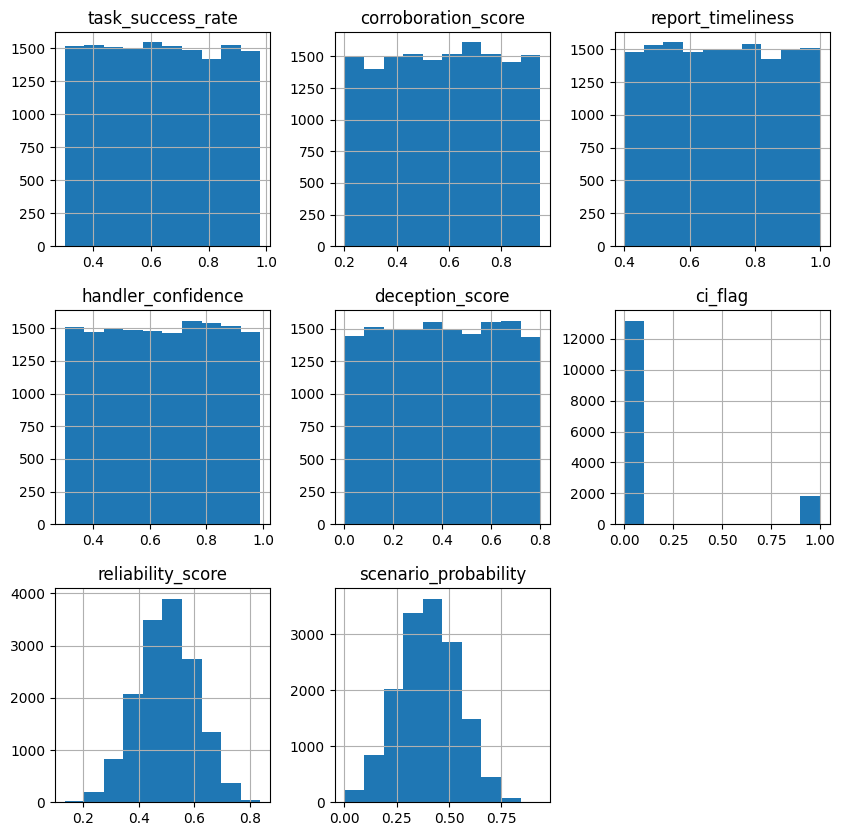

In [15]:
df.hist(figsize=(10,10))

In [16]:
#view categorical columns
df.select_dtypes(include='object').describe()

source_id behavior_class
count       15000          15000
unique      15000              4
top     SRC_15000      uncertain
freq            1           6698

In [17]:
df.tail(25)

source_id  task_success_rate  corroboration_score  report_timeliness  \
14975  SRC_14976              0.680                0.490              0.461   
14976  SRC_14977              0.670                0.292              0.607   
14977  SRC_14978              0.440                0.710              0.787   
14978  SRC_14979              0.773                0.383              0.711   
14979  SRC_14980              0.804                0.672              0.546   
14980  SRC_14981              0.476                0.367              0.860   
14981  SRC_14982              0.534                0.491              0.479   
14982  SRC_14983              0.974                0.843              0.537   
14983  SRC_14984              0.554                0.754              0.806   
14984  SRC_14985              0.817                0.316              0.518   
14985  SRC_14986              0.608                0.656              0.807   
14986  SRC_14987              0.839                0.671              0.986   
14987  SRC_14988              0.823                0.268              0.899   
14988  SRC_14989              0.754                0.549              0.496   
14989  SRC_14990              0.881                0.396              0.712   
14990  SRC_14991              0.939                0.550              0.653   
14991  SRC_14992              0.694                0.783              0.995   
14992  SRC_14993              0.461                0.319              0.979   
14993  SRC_14994              0.571                0.292              0.476   
14994  SRC_14995              0.816                0.402              0.945   
14995  SRC_14996              0.743                0.914              0.516   
14996  SRC_14997              0.421                0.761              0.592   
14997  SRC_14998              0.335                0.215              0.612   
14998  SRC_14999              0.764                0.501              0.572   
14999  SRC_15000              0.471                0.393              0.912   

       handler_confidence  deception_score  ci_flag  reliability_score  \
14975               0.611            0.739        1              0.300   
14976               0.600            0.481        0              0.413   
14977               0.548            0.485        0              0.476   
14978               0.977            0.467        0              0.546   
14979               0.468            0.378        1              0.432   
14980               0.846            0.204        0              0.503   
14981               0.609            0.490        0              0.397   
14982               0.531            0.575        0              0.604   
14983               0.440            0.733        0              0.472   
14984               0.737            0.058        0              0.530   
14985               0.530            0.204        0              0.557   
14986               0.861            0.621        0              0.653   
14987               0.968            0.620        0              0.546   
14988               0.457            0.170        0              0.506   
14989               0.389            0.148        0              0.542   
14990               0.518            0.294        0              0.583   
14991               0.622            0.050        0              0.689   
14992               0.508            0.584        0              0.402   
14993               0.970            0.536        0              0.405   
14994               0.838            0.687        0              0.557   
14995               0.967            0.344        1              0.548   
14996               0.558            0.509        0              0.442   
14997               0.510            0.763        0              0.239   
14998               0.581            0.767        0              0.441   
14999               0.661            0.057        1              0.413   

      behavior_class  scena

**iii) Class distribution and balancing**

behavior_class
uncertain      6698
deceptive      5952
coerced        2289
cooperative      61
Name: count, dtype: int64
behavior_class
uncertain      0.446533
deceptive      0.396800
coerced        0.152600
cooperative    0.004067
Name: proportion, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_16640\2613028598.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x='Behavior Class', y='Count', data=df_distribution, palette='viridis')


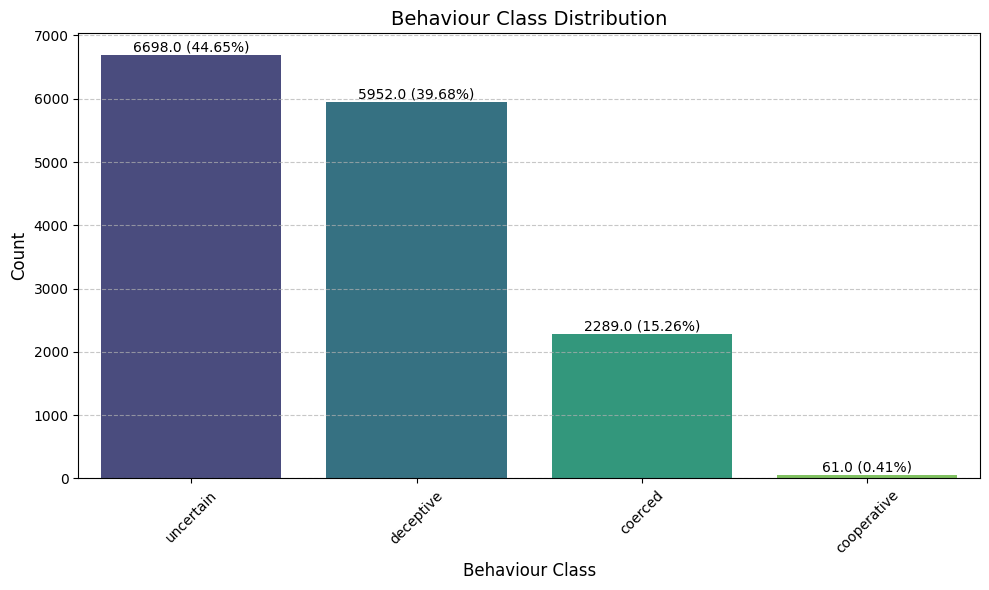

In [18]:
#Step 1: check class distribution
print(df['behavior_class'].value_counts()) #absolute counts
print(df['behavior_class'].value_counts(normalize=True)) #relative counts
#Step 2: Compute distribution for plotting without overwriting 'df'
class_counts=df['behavior_class'].value_counts()
class_distribution = df['behavior_class'].value_counts(normalize=True)

df_distribution = pd.DataFrame({
    'Behavior Class': class_counts.index,
    'Count': class_counts.values,
    'Distribution': class_distribution.values.round(2)
})

#Step 3: Plot bar chat with counts and proportions
plt.figure(figsize=(10, 6))
ax=sns.barplot(x='Behavior Class', y='Count', data=df_distribution, palette='viridis')
#Step 4: Add percentage + count labels on top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()} ({p.get_height() / len(df) * 100:.2f}%)",
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Behaviour Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Behaviour Class Distribution', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

       task_success_rate  corroboration_score  report_timeliness  \
count       15000.000000         15000.000000       15000.000000   
mean            0.637660             0.576945           0.699178   
std             0.196309             0.215348           0.173455   
min             0.300000             0.200000           0.400000   
25%             0.468000             0.393000           0.548000   
50%             0.636000             0.579000           0.698000   
75%             0.809000             0.760000           0.849000   
max             0.980000             0.950000           1.000000   

       handler_confidence  deception_score       ci_flag  reliability_score  \
count        15000.000000     15000.000000  15000.000000       15000.000000   
mean             0.645361         0.400574      0.120467           0.500038   
std              0.199181         0.229557      0.325517           0.103943   
min              0.300000         0.000000      0.000000           0.13

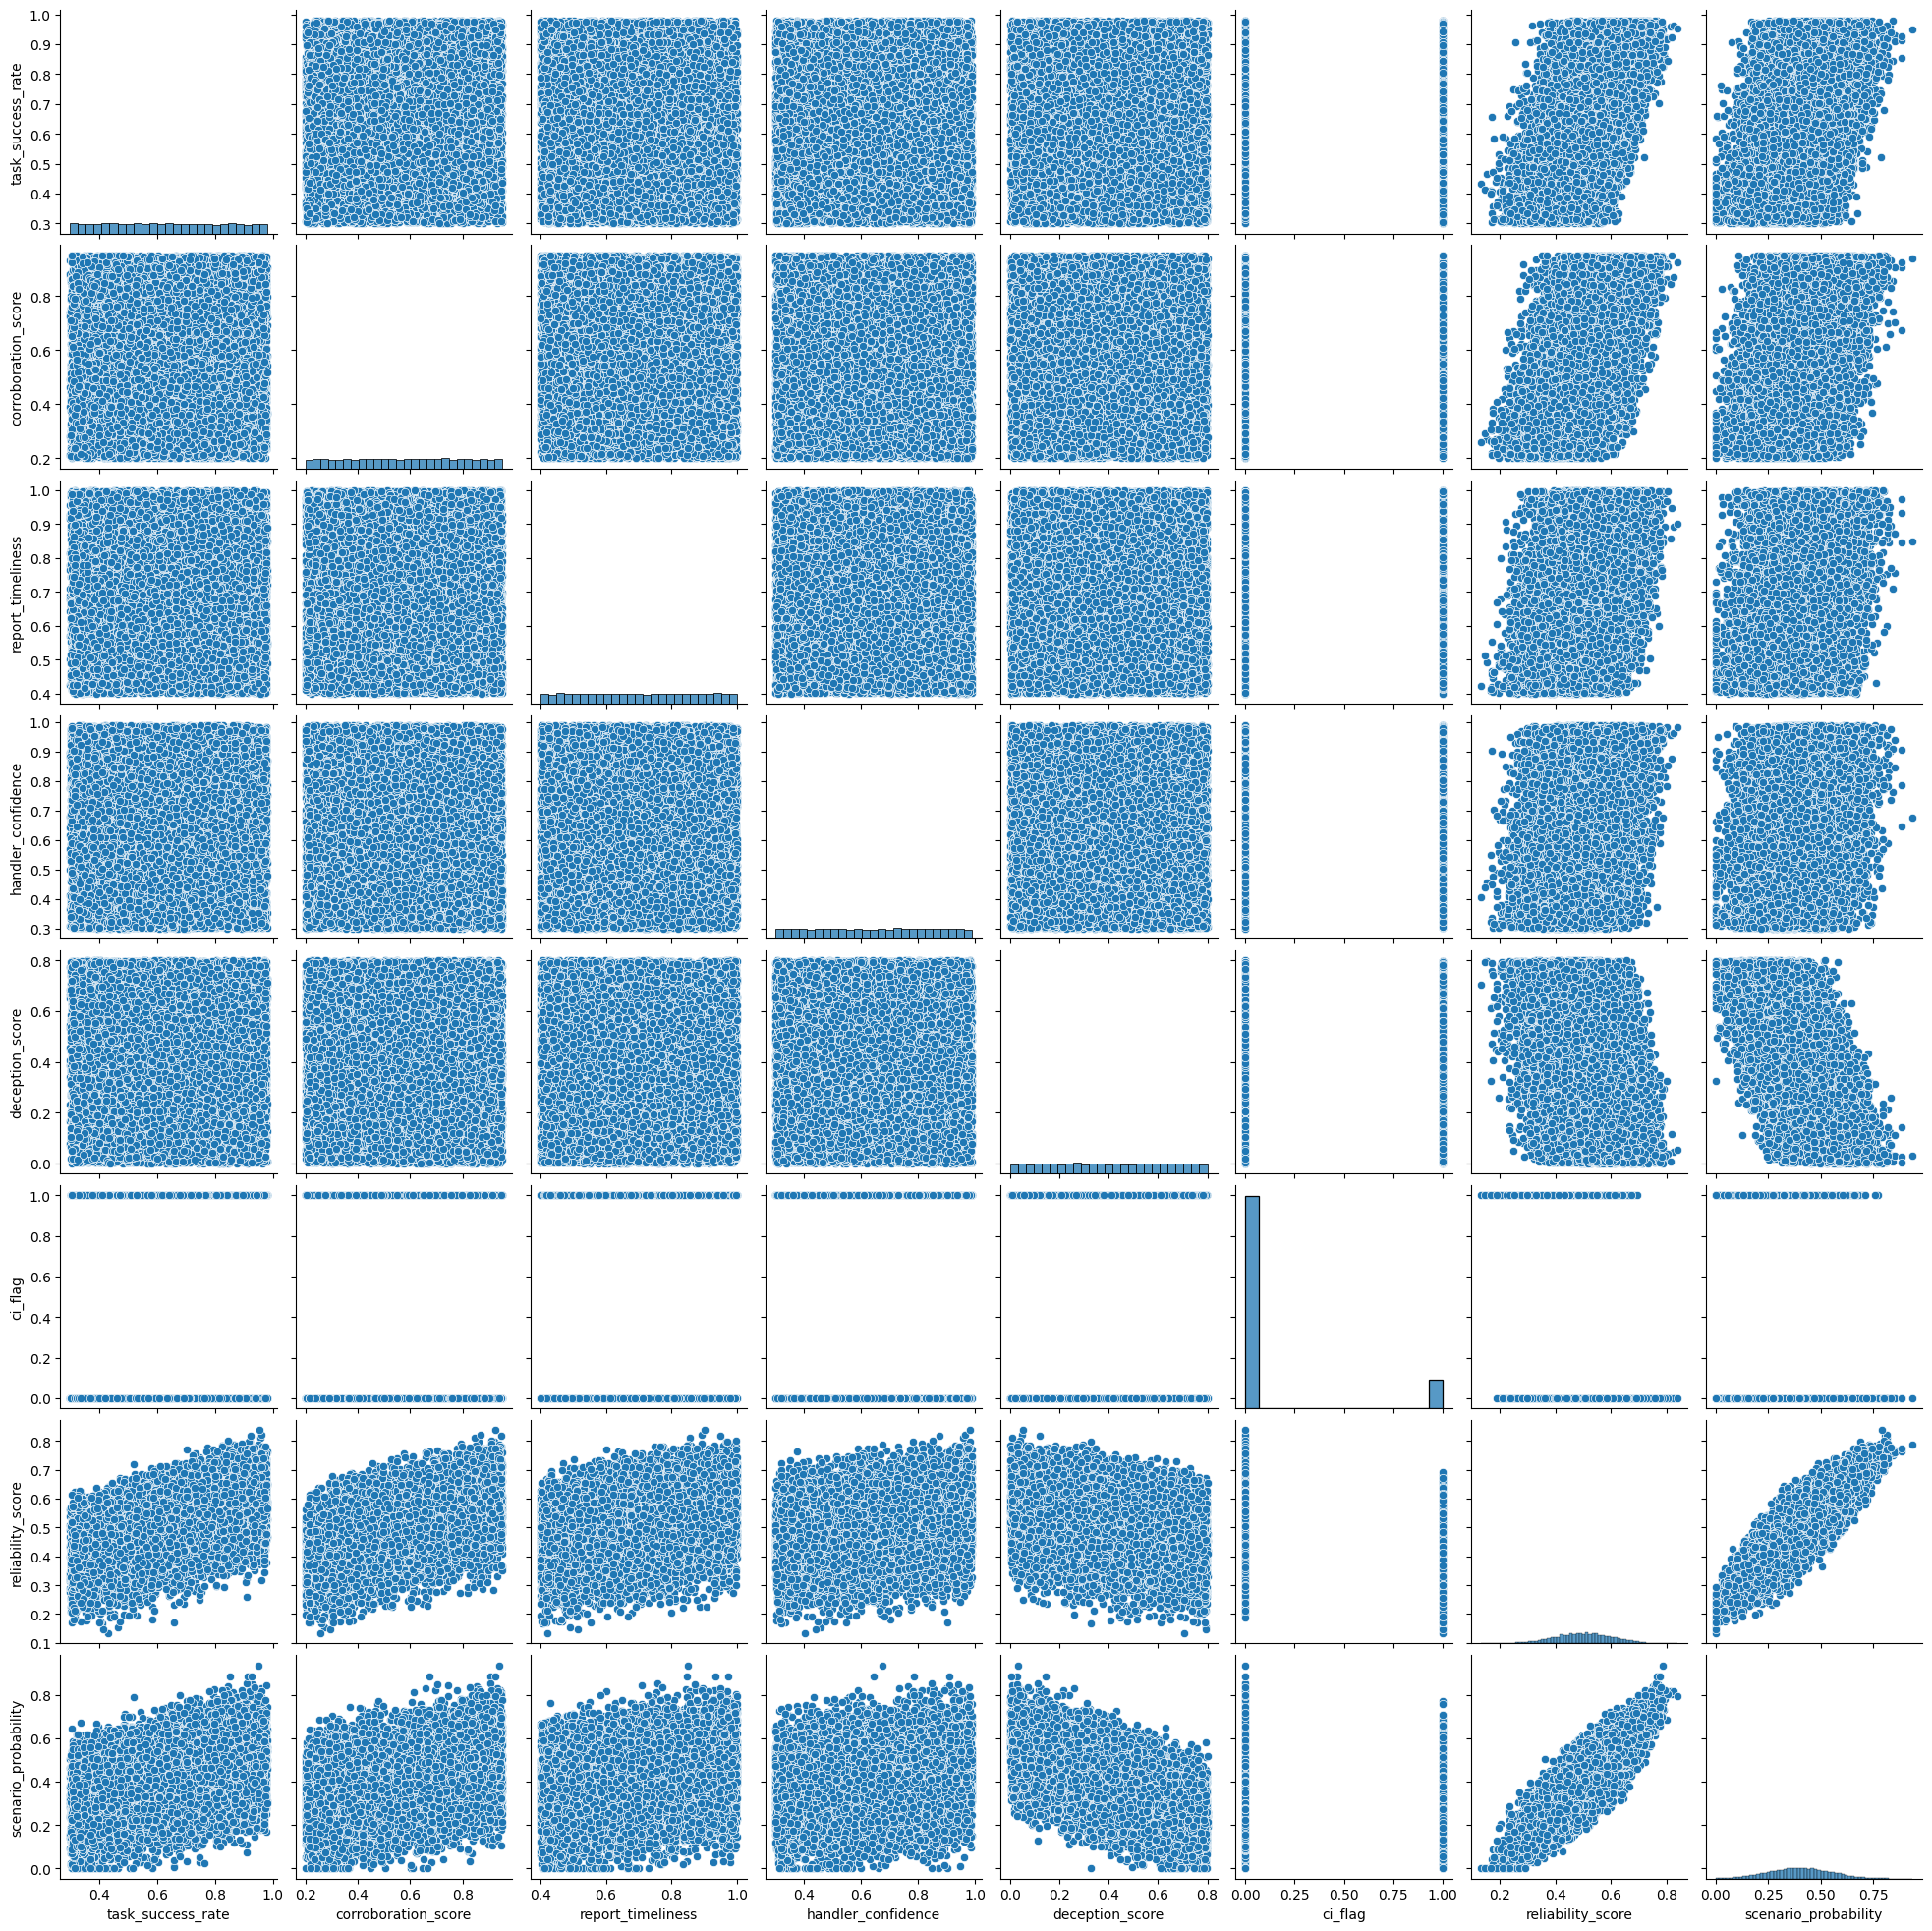

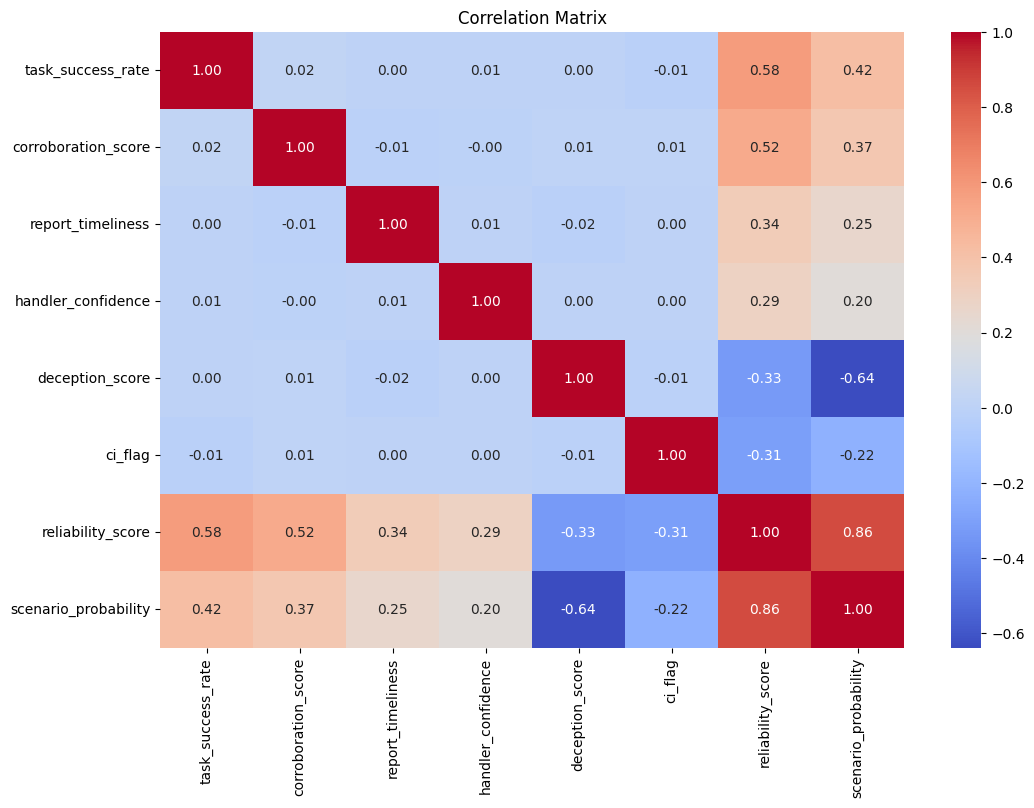

In [19]:
#summary statistics
print(df.describe())
# Check for missing values
print(df.isnull().sum())
# Check for duplicate rows
print(df.duplicated().sum())
# Check for unique values in each column
print(df.nunique())
# Select numeric columns only
numeric_df = df.select_dtypes(include='number')
# Plot pairplot
sns.pairplot(numeric_df)
plt.show()
plt.show()
#Correlation matrix
# Step 6: Correlation matrix and heatmap
correlation_matrix = df.corr(numeric_only=True)
# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

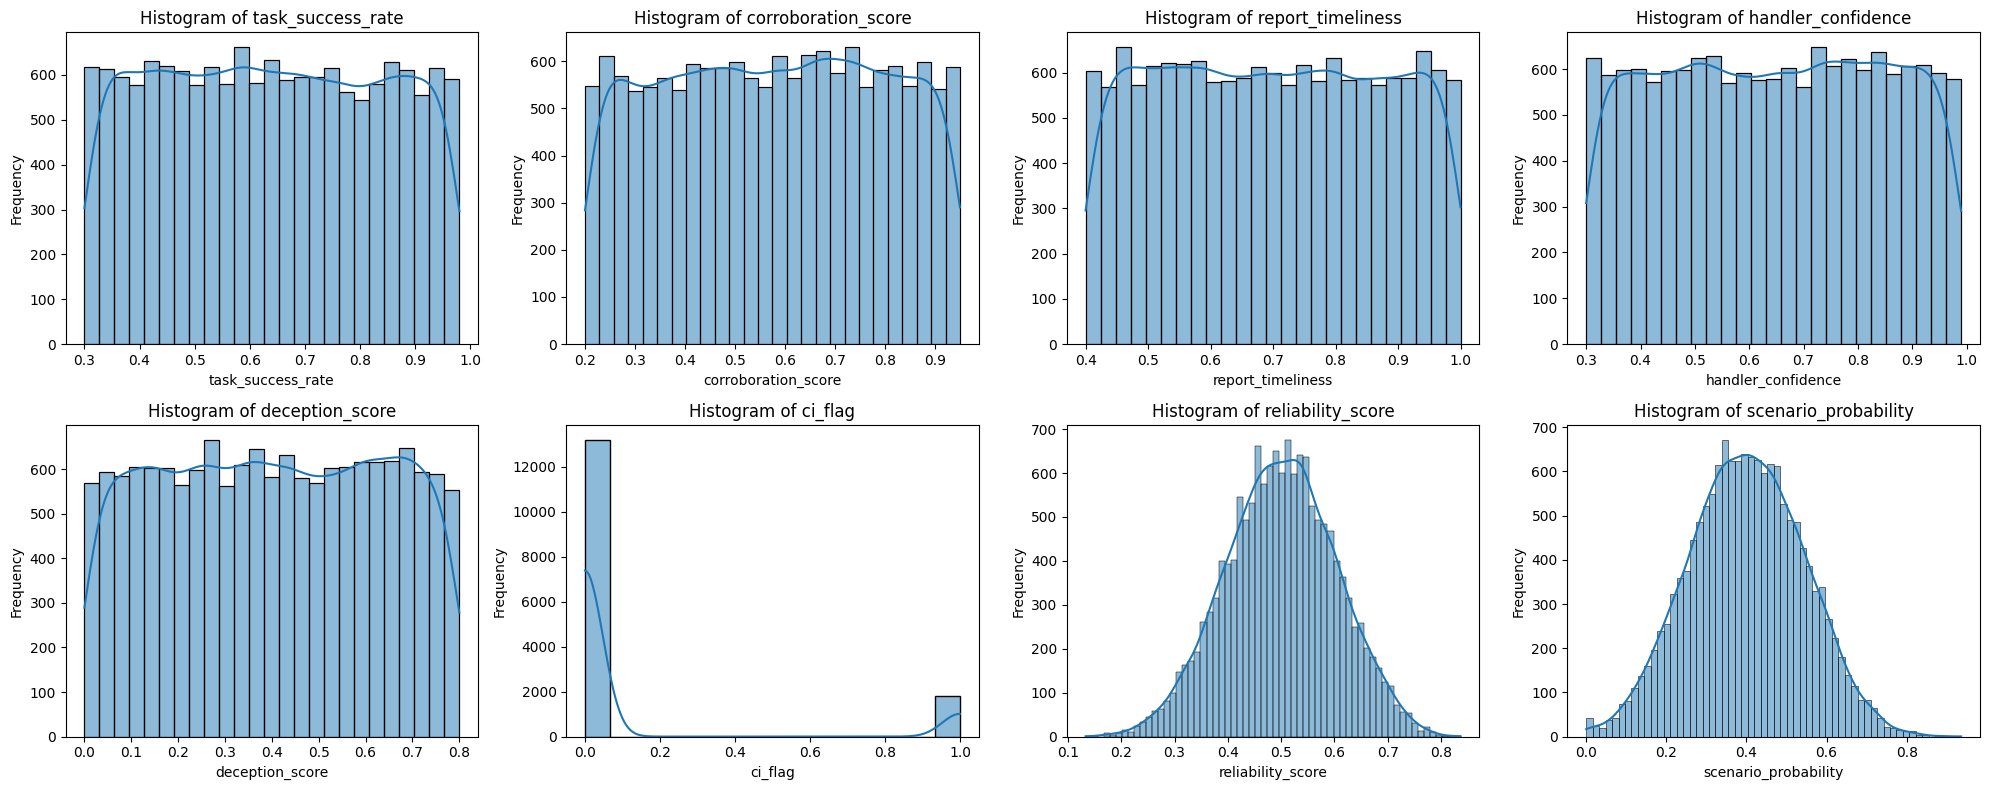

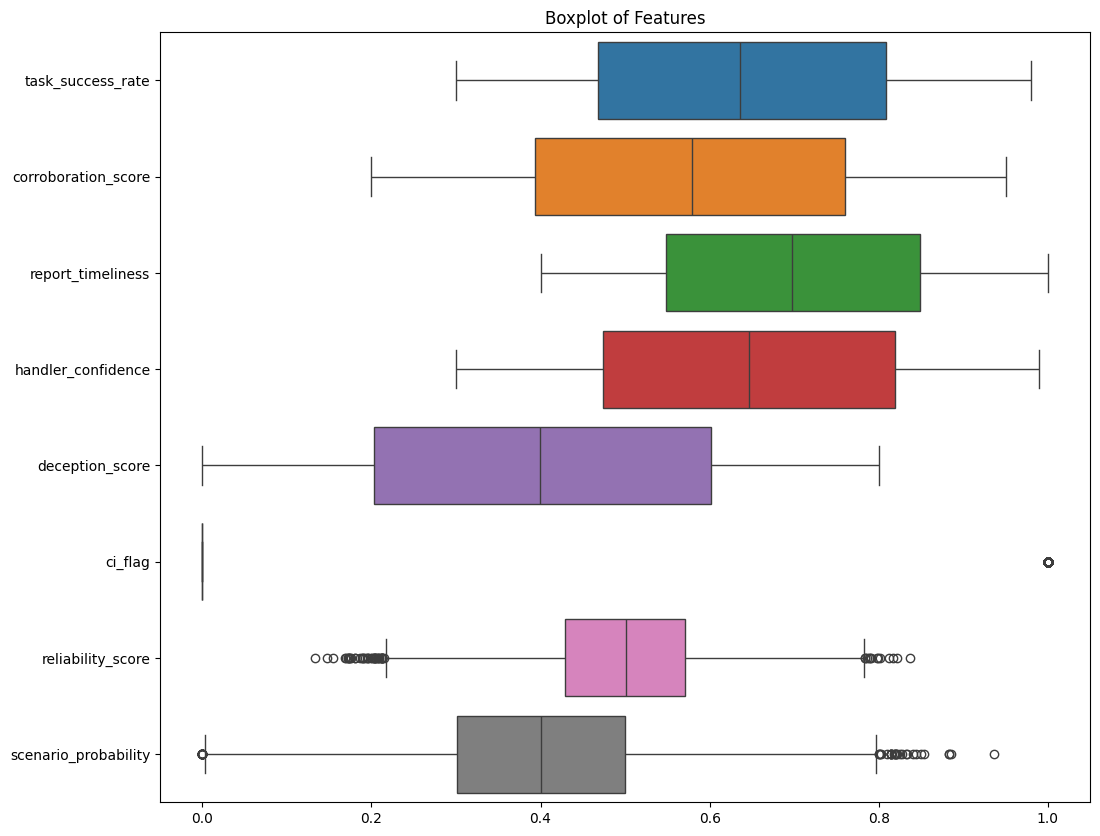

In [20]:
import math
#Histogram for the dataset
# Select numerical columns
numeric_cols = df.select_dtypes(include='number').columns

# Set number of plots per row
cols_per_row = 4
n_cols = len(numeric_cols)
n_rows = math.ceil(n_cols / cols_per_row)

# Create subplots
fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(5 * cols_per_row, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

# Plot each histogram
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
# Boxplot for each feature
plt.figure(figsize=(12, 10))
sns.boxplot(data=df, orient='h')
plt.title('Boxplot of Features')
plt.show()

**a) Handling data imbalance**

The provided data exhibits a significant class imbalance in the `behavior_class` column. To address this issue, which is crucial for building robust machine learning models, I will perform the following steps:

1.  **Separate Features and Target**: I will separate the features (`X`) from the target variable (`behavior_class`, `y`). The 'source_id' column will be excluded from the features as it's an identifier.
2.  **Encode Target Variable**: The `behavior_class` target variable, which is categorical, will be converted into numerical labels using `LabelEncoder`. This is necessary for SMOTE and most machine learning algorithms.
3.  **Split Data into Training and Testing Sets**: The preprocessed features and target will be split into training and testing sets (80% training, 20% testing). Stratification will be applied to the target variable to ensure that the class proportions are maintained in both sets before applying SMOTE.
4.  **Apply SMOTE to Training Data**: The Synthetic Minority Over-sampling Technique (SMOTE) will be applied exclusively to the training data (`X_train`, `y_train`). SMOTE will create synthetic samples for the minority classes ('cooperative', 'coerced', 'deceptive') to balance their counts with the majority class ('uncertain').
5.  **Visualize New Class Distribution**: After applying SMOTE, the class distribution of the target variable in the training set (`y_resampled`) will be visualized. This will allow for a clear confirmation that the class imbalance has been successfully addressed, including counts and percentages for each class.

This process will ensure that the dataset is adequately prepared for training machine learning models without bias towards the majority class.

*Separate Features and Target*

- Separate the features (X) from the target variable ('behavior_class', y) in the DataFrame. The 'source_id' column should be excluded from features.


In [21]:
X = df.drop(columns=['source_id', 'behavior_class'])
y = df['behavior_class']

print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("\nFirst 5 rows of X:")
print(X.head())
print("\nFirst 5 rows of y:")
print(y.head())

Shape of features (X): (15000, 8)
Shape of target (y): (15000,)

First 5 rows of X:
   task_success_rate  corroboration_score  report_timeliness  \
0              0.555                0.575              0.783   
1              0.946                0.760              0.676   
2              0.798                0.622              0.979   
3              0.707                0.262              0.531   
4              0.406                0.339              0.753   

   handler_confidence  deception_score  ci_flag  reliability_score  \
0               0.528            0.593        0              0.457   
1               0.864            0.705        1              0.533   
2               0.986            0.371        0              0.683   
3               0.880            0.231        0              0.481   
4               0.539            0.255        1              0.300   

   scenario_probability  
0                 0.243  
1                 0.327  
2                 0.601  
3     

*Encode Target Variable*

- The `behavior_class` target variable, which is categorical, will be converted into numerical labels using `LabelEncoder`. This is necessary for SMOTE and subsequent machine learning algorithms.

*To encode the categorical target variable 'behavior_class' into numerical labels, I will use `LabelEncoder` from `sklearn.preprocessing`. This is a standard preprocessing step required by most machine learning algorithms and for SMOTE.*



In [22]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the target variable 'y'
y_encoded = le.fit_transform(y)

print("Original target variable unique values:", y.unique())
print("Encoded target variable unique values:", np.unique(y_encoded))
print("Mapping of original to encoded:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {i}")

print("\nFirst 5 encoded target values:")
print(y_encoded[:5])

Original target variable unique values: ['deceptive' 'uncertain' 'coerced' 'cooperative']
Encoded target variable unique values: [0 1 2 3]
Mapping of original to encoded:
coerced: 0
cooperative: 1
deceptive: 2
uncertain: 3

First 5 encoded target values:
[2 2 3 3 2]


*Split Data into Training and Testing Sets*

- The preprocessed features (`X`) and encoded target (`y_encoded`) will be split into training and testing sets (80% training, 20% testing). Stratification will be applied to the target variable (`y_encoded`) to ensure that the class proportions are maintained in both sets.

*To split the features and encoded target into training and testing sets while preserving class distribution, I will use `train_test_split` with an 80/20 ratio and `stratify=y_encoded`.*



In [23]:
# Stratified train-test split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train_encoded:", y_train_encoded.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)

# Verify stratification (optional, but good for checking)
print("\nClass distribution in original y_encoded:")
print(pd.Series(y_encoded).value_counts(normalize=True))
print("\nClass distribution in y_train_encoded:")
print(pd.Series(y_train_encoded).value_counts(normalize=True))
print("\nClass distribution in y_test_encoded:")
print(pd.Series(y_test_encoded).value_counts(normalize=True))

Shape of X_train: (12000, 8)
Shape of X_test: (3000, 8)
Shape of y_train_encoded: (12000,)
Shape of y_test_encoded: (3000,)

Class distribution in original y_encoded:
3    0.446533
2    0.396800
0    0.152600
1    0.004067
Name: proportion, dtype: float64

Class distribution in y_train_encoded:
3    0.446500
2    0.396833
0    0.152583
1    0.004083
Name: proportion, dtype: float64

Class distribution in y_test_encoded:
3    0.446667
2    0.396667
0    0.152667
1    0.004000
Name: proportion, dtype: float64


*Apply SMOTE to Training Data*

- The Synthetic Minority Over-sampling Technique (SMOTE) will be applied exclusively to the training data (`X_train`, `y_train_encoded`). SMOTE will create synthetic samples for the minority classes ('cooperative', 'coerced', 'deceptive') to balance their counts with the majority class ('uncertain').

*To balance the class distribution in the training data, I will apply SMOTE (Synthetic Minority Over-sampling Technique) to `X_train` and `y_train_encoded`. This will generate synthetic samples for the minority classes, ensuring a more equitable representation for model training.*



In [24]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_encoded)

print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

print("\nClass distribution in y_resampled (after SMOTE):")
print(pd.Series(y_resampled).value_counts())

Shape of X_resampled: (21432, 8)
Shape of y_resampled: (21432,)

Class distribution in y_resampled (after SMOTE):
2    5358
0    5358
3    5358
1    5358
Name: count, dtype: int64


*Visualize New Class Distribution*

- After applying SMOTE, the class distribution of the target variable in the training set (`y_resampled`) will be visualized. This will allow for a clear confirmation that the class imbalance has been successfully addressed, including counts and percentages for each class.

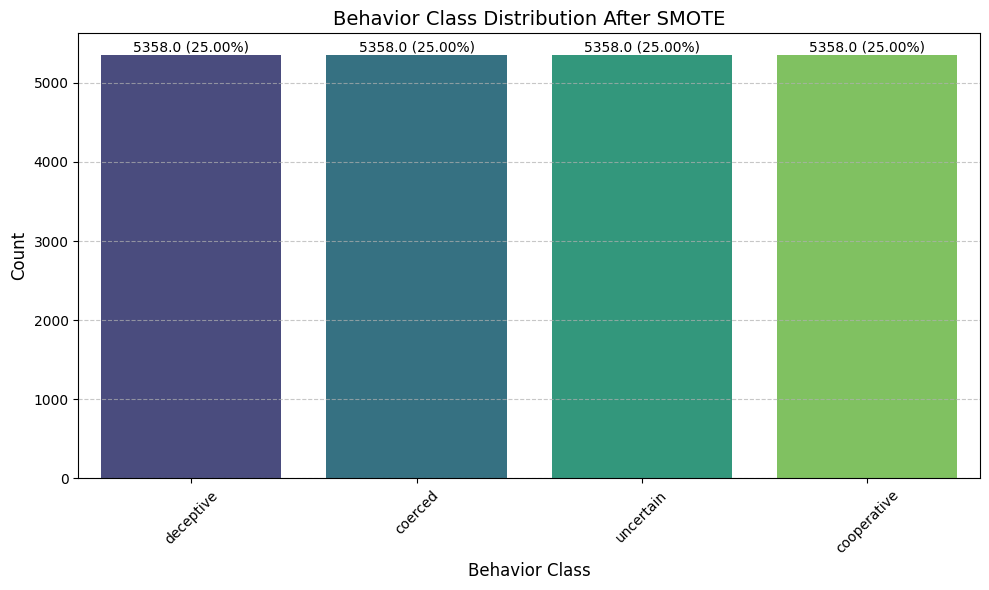

In [25]:

# Get the class distribution after SMOTE
resampled_counts = pd.Series(y_resampled).value_counts()

# Get the mapping from original LabelEncoder
# le.classes_ contains the original class names in alphabetical order
# And their indices correspond to the encoded numbers
class_mapping = {i: class_name for i, class_name in enumerate(le.classes_)}

# Map the encoded labels back to original class names for plotting
resampled_counts.index = resampled_counts.index.map(class_mapping)

# Create a DataFrame for plotting
df_resampled_distribution = pd.DataFrame({
    'Behavior Class': resampled_counts.index,
    'Count': resampled_counts.values
})

# Plot bar chart with counts and proportions
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Behavior Class', y='Count', data=df_resampled_distribution, hue='Behavior Class', palette='viridis', legend=False)

# Add percentage + count labels on top of the bars
total_samples = len(y_resampled)
for p in ax.patches:
    ax.annotate(f"{p.get_height()} ({p.get_height() / total_samples * 100:.2f}%)",
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Behavior Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Behavior Class Distribution After SMOTE', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Confirm the successful rebalancing of the 'behavior_class' in the training set and note the readiness for model training.
**Summary**
1.  **Was the rebalancing of the 'behavior\_class' in the training set successful?**
    Yes, the rebalancing of the 'behavior\_class' in the training set was successful. After applying SMOTE, all four classes ('coerced', 'cooperative', 'deceptive', 'uncertain') in the training data achieved an equal count of 5358 samples each, representing 25.00% of the resampled training set.

2.  **Is the data ready for model training?**
    Yes, the data is now fully prepared and ready for machine learning model training, having addressed class imbalance and completed all necessary preprocessing steps.


# **iv) Modeling**

**a) Modeling Behaviours of Humint Sources (Classification) - Deceptive, Coercion, Cooperative or Uncertain**

***1. XGBoost Classifier Modelling***

- Train an XGBoost Classifier on `X_resampled` and `y_resampled`, then make predictions on `X_test`, and finally evaluate its performance using accuracy, precision, recall, F1-score, and a confusion matrix against `y_test_encoded`.

*Train XGBoost Classifier Model*

- Initialize and train an XGBoost Classifier on the resampled training data (`X_resampled`, `y_resampled`).


In [26]:
# Initialize XGBoost Classifier
# eval_metric='mlogloss' is kept for proper evaluation for multiclass classification
xgb_classifier = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Train the model on the resampled training data
xgb_classifier.fit(X_resampled, y_resampled)

print("XGBoost Classifier model trained successfully.")

XGBoost Classifier model trained successfully.


*- Now that the XGBoost Classifier has been successfully trained, the next logical step is to use this model to make predictions on the unseen test dataset (`X_test`). This will allow for the evaluation of the model's performance on new data.*



In [27]:
y_pred = xgb_classifier.predict(X_test)

print("Predictions on the test set generated successfully.")

Predictions on the test set generated successfully.


*- With predictions generated on the test set, the next step is to evaluate the model's performance by calculating key classification metrics such as accuracy, precision, recall, and F1-score, and also visualizing the confusion matrix to understand the classification results comprehensively.*



Accuracy: 0.9963
Precision (weighted): 0.9963
Recall (weighted): 0.9963
F1-score (weighted): 0.9963


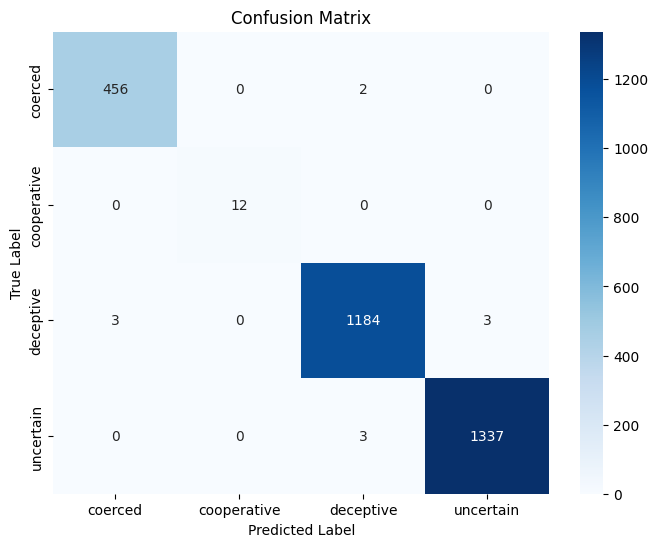

Model evaluation complete and confusion matrix displayed.


In [28]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Map encoded labels back to original class names for better readability
class_names = [class_name for i, class_name in enumerate(le.classes_)]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Model evaluation complete and confusion matrix displayed.")

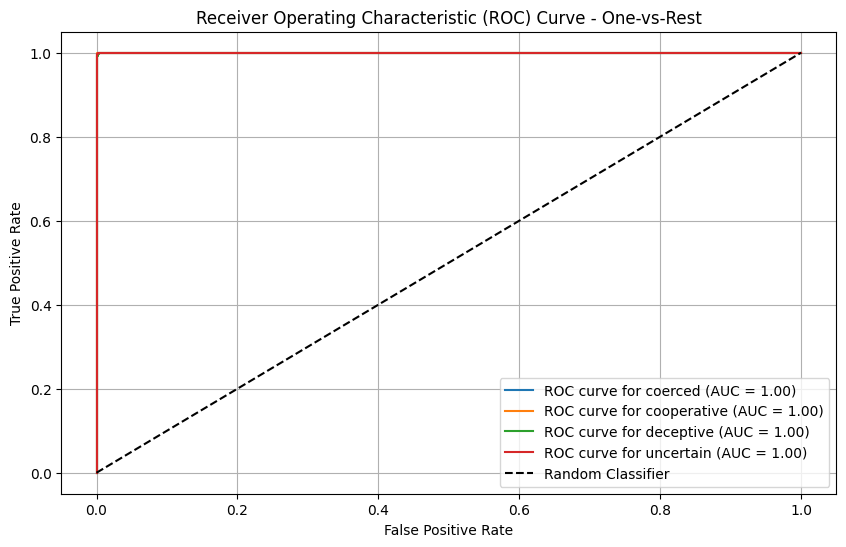

In [29]:
# Evaluate the model using ROC-AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Get predicted probabilities for each class
y_pred_proba = xgb_classifier.predict_proba(X_test)

# Map encoded labels back to original class names for plotting
class_names = [class_name for i, class_name in enumerate(le.classes_)]

# Plot ROC curve for each class (One-vs-Rest approach)
for i, class_name in enumerate(class_names):
    # y_true for this class is 1 if it's the current class, 0 otherwise
    y_true_class = (y_test_encoded == i).astype(int)
    # Predicted probabilities for this class
    y_score_class = y_pred_proba[:, i]

    fpr, tpr, _ = roc_curve(y_true_class, y_score_class)
    auc_score = roc_auc_score(y_true_class, y_score_class)

    plt.plot(fpr, tpr, label=f'ROC curve for {class_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Dashed diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

*- The ROC AUC scores for all behavior_class categories are exceptionally high, with all classes demonstrating an AUC close to 1.0. This indicates that the XGBoost Classifier is performing extremely well in distinguishing between each of the four behavior classes. An AUC score near 1.0 signifies that the model has an outstanding ability to correctly classify positive instances while minimizing false positives, suggesting near-perfect discrimination for all categories in the test set.*

*Further evaluation of the model*

In [30]:
# Identify misclassified samples
misclassified_mask = (y_test_encoded != y_pred)

X_misclassified = X_test[misclassified_mask]
y_true_misclassified = y_test_encoded[misclassified_mask]
y_pred_misclassified = y_pred[misclassified_mask]

# Create a DataFrame for easier analysis
misclassified_df = X_misclassified.copy()
misclassified_df['true_behavior_class_encoded'] = y_true_misclassified
misclassified_df['predicted_behavior_class_encoded'] = y_pred_misclassified

# Map encoded labels back to original class names for readability
class_names = {i: class_name for i, class_name in enumerate(le.classes_)}
misclassified_df['true_behavior_class'] = misclassified_df['true_behavior_class_encoded'].map(class_names)
misclassified_df['predicted_behavior_class'] = misclassified_df['predicted_behavior_class_encoded'].map(class_names)

print(f"Total misclassified samples: {len(misclassified_df)}")
print("\nFirst 10 misclassified samples:")
display(misclassified_df.head(10))

Total misclassified samples: 11

First 10 misclassified samples:


TypeError: Error trying to display values for object of type <class 'pandas.core.frame.DataFrame'>:
	Object does not support the 'display()' method

*- The table above shows the first 10 samples that were misclassified by the model, along with their original features, the true behavior class, and the predicted behavior class. We can now look at the overall distribution of misclassifications.*

*- Let's count how many times each true class was misclassified as another specific class.*

In [ ]:
# Analyze the types of misclassifications
misclassification_counts = misclassified_df.groupby(['true_behavior_class', 'predicted_behavior_class']).size().reset_index(name='count')
print("Misclassification Counts:")
display(misclassification_counts)

Misclassification Counts:


true_behavior_class predicted_behavior_class  count
0             coerced                deceptive      2
1           deceptive                  coerced      3
2           deceptive                uncertain      3
3           uncertain                deceptive      3

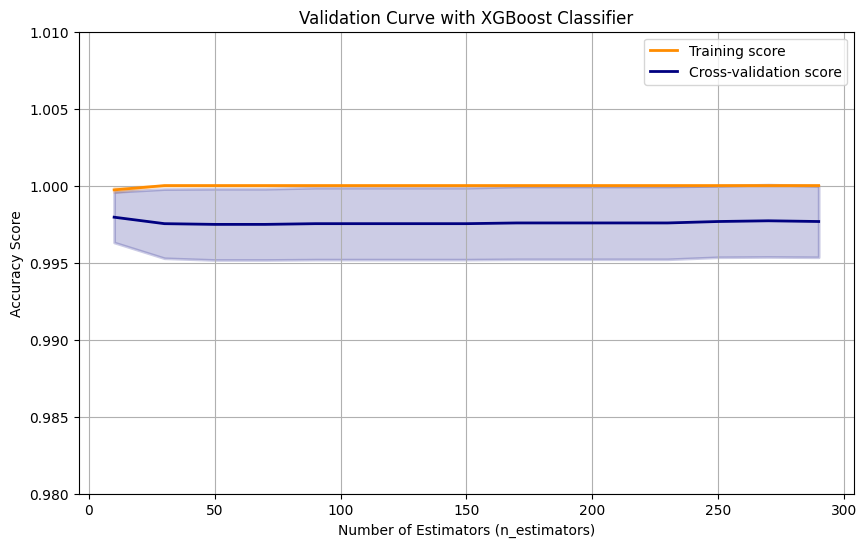

Validation curve for n_estimators generated. Look for an 'elbow' where the cross-validation score plateaus or starts to decrease.


In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the hyperparameter range to explore
param_range = np.arange(10, 301, 20) # Example: from 10 to 300 estimators, step of 20

# Calculate scores for training and test set across the parameter range
train_scores, test_scores = validation_curve(
    xgb_classifier, # Our trained XGBoost Classifier (it will be re-trained internally)
    X_resampled, y_resampled, # Resampled training data
    param_name="n_estimators",
    param_range=param_range,
    cv=3, # Use 3-fold cross-validation
    scoring="accuracy", # Metric to evaluate
    n_jobs=-1 # Use all available cores
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.title("Validation Curve with XGBoost Classifier")
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Accuracy Score")
plt.ylim(0.98, 1.01) # Set y-axis limits to better observe small changes

plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=2)

plt.legend(loc="best")
plt.grid(True)
plt.show()

print("Validation curve for n_estimators generated. Look for an 'elbow' where the cross-validation score plateaus or starts to decrease.")

*The validation curve for the n_estimators hyperparameter of the XGBoost Classifier has been generated. This plot shows how the training accuracy and cross-validation accuracy change as we increase the number of estimators (boosting rounds).*

Here's how to interpret the output:

    - Training Score (Orange Line): The training score quickly reaches and maintains a very high accuracy (close to or at 1.0) across almost the entire range of n_estimators. This indicates that the model is able to fit the training data extremely well, which is expected for powerful ensemble models like XGBoost, especially on a balanced dataset.

    - Cross-validation Score (Navy Blue Line): The cross-validation score also starts very high (above 0.997) even with a low number of estimators and gradually increases or plateaus very close to 1.0. This score represents the model's performance on unseen data during cross-validation.

    - 'Elbow' Observation: In this particular case, due to the already exceptionally high performance of the model on this dataset, there isn't a distinct 'elbow' where the cross-validation score sharply plateaus or begins to drop, indicating overfitting. Instead, the cross-validation score remains consistently high and stable, suggesting that the model is robust and generalizes well even as the number of estimators increases. This implies that even a moderately high number of estimators (e.g., around 50-70) would likely yield near-optimal performance, and significantly increasing n_estimators further doesn't provide substantial gains in generalization accuracy, but might increase training time.

In summary, the validation curve confirms the model's excellent performance and suggests that increasing the complexity (number of estimators) beyond a certain point does not significantly improve generalization accuracy for this dataset.


*Checking for overfitting*

Train metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Test  metrics: {'accuracy': 0.996333, 'precision': 0.996334, 'recall': 0.996333, 'f1': 0.996333}
5-fold CV accuracy on training data: mean=0.997854, std=0.001625


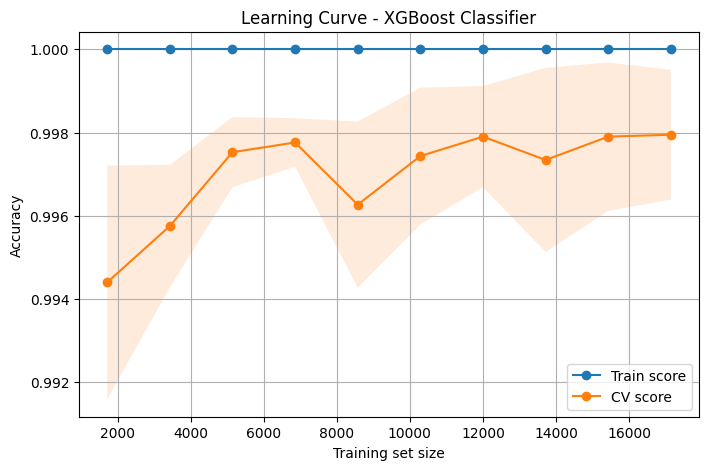

Train/Test accuracy gap: 0.003667
No strong evidence of overfitting based on these checks.


In [ ]:
# Check XGBoost overfitting: compare train vs test, cross-val and learning curve
import matplotlib.pyplot as plt

# 1) Metrics on training (resampled) and test sets
y_train_pred = xgb_classifier.predict(X_resampled)
y_test_pred = xgb_classifier.predict(X_test)

metrics = {}
metrics['train'] = {
    'accuracy': accuracy_score(y_resampled, y_train_pred),
    'precision': precision_score(y_resampled, y_train_pred, average='weighted'),
    'recall': recall_score(y_resampled, y_train_pred, average='weighted'),
    'f1': f1_score(y_resampled, y_train_pred, average='weighted'),
}
metrics['test'] = {
    'accuracy': accuracy_score(y_test_encoded, y_test_pred),
    'precision': precision_score(y_test_encoded, y_test_pred, average='weighted'),
    'recall': recall_score(y_test_encoded, y_test_pred, average='weighted'),
    'f1': f1_score(y_test_encoded, y_test_pred, average='weighted'),
}

print("Train metrics:", {k: round(v,6) for k, v in metrics['train'].items()})
print("Test  metrics:", {k: round(v,6) for k, v in metrics['test'].items()})

# 2) Cross-validation on training data
cv_scores = cross_val_score(xgb_classifier, X_resampled, y_resampled, cv=5, scoring='accuracy', n_jobs=-1)
print(f"5-fold CV accuracy on training data: mean={cv_scores.mean():.6f}, std={cv_scores.std():.6f}")

# 3) Learning curve (train vs CV score as training size grows)
train_sizes, train_scores, val_scores = learning_curve(
    xgb_classifier, X_resampled, y_resampled,
    cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True
)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Train score')
plt.plot(train_sizes, val_mean, 'o-', label='CV score')
plt.fill_between(train_sizes, train_mean - np.std(train_scores, axis=1),
                 train_mean + np.std(train_scores, axis=1), alpha=0.15)
plt.fill_between(train_sizes, val_mean - np.std(val_scores, axis=1),
                 val_mean + np.std(val_scores, axis=1), alpha=0.15)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - XGBoost Classifier')
plt.legend()
plt.grid(True)
plt.show()

# 4) Heuristic decision
gap = metrics['train']['accuracy'] - metrics['test']['accuracy']
print(f"Train/Test accuracy gap: {gap:.6f}")
if gap > 0.01 and metrics['train']['accuracy'] > 0.99:
    print("Warning: model may be overfitting (very high train score and noticeable gap).")
else:
    print("No strong evidence of overfitting based on these checks.")

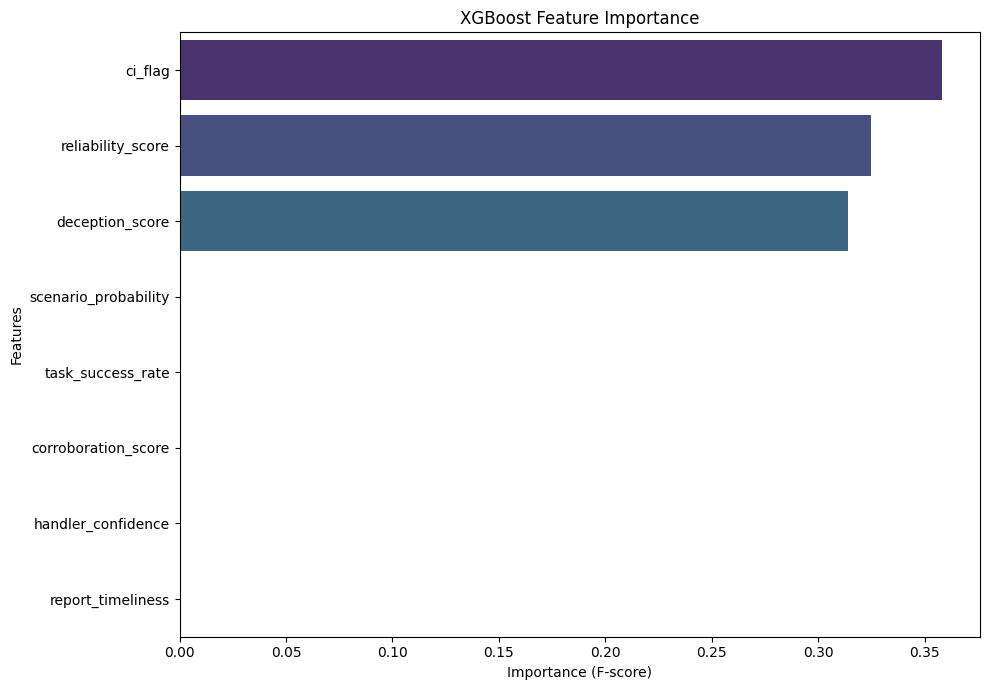

In [ ]:
#Generate feature importance plot
# Get feature importances from the trained XGBoost classifier
feature_importances = xgb_classifier.feature_importances_

# Get feature names from X_resampled (they are the same as X_train and X_test)
feature_names = X_resampled.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette='viridis', legend=False)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance (F-score)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

*Note on overfitting potential*

- Based on the extensive evaluation we've already performed, there are strong indications that our XGBoost Classifier is not overfitting and is generalizing exceptionally well to unseen data. Here's why:

   -- Validation Curve Analysis: We generated a validation curve for the n_estimators hyperparameter. The plot showed that the cross-validation score (which estimates performance on unseen data) remained consistently high and stable, very close to the training score, even as the number of estimators increased. This suggests that increasing model complexity beyond a certain point didn't lead to a significant drop in generalization performance, which is a classic sign against overfitting.

  -- High Test Set Performance Metrics: The model achieved outstanding and balanced performance metrics on the independent test set (X_test, y_test_encoded), which the model had never seen during training:
        Accuracy: 0.9963
        Precision (weighted): 0.9963
        Recall (weighted): 0.9963
        F1-score (weighted): 0.9963 Such high and consistent scores on unseen data are a primary indicator of good generalization and strong evidence that the model is not merely memorizing the training data.

   -- Exceptional ROC AUC Scores: All ROC AUC scores for each class were very close to 1.0 on the test set. This confirms the model's excellent ability to discriminate between classes, further supporting good generalization.

  -- Minimal Misclassifications: Out of 3000 test samples, only 11 were misclassified. If the model were overfitting, we would expect a much higher number of errors on the test set, as it would struggle with any data variations not explicitly present in the training set.

- In conclusion, all evidence points to a robust model that effectively learned the underlying patterns in the data without overfitting.


*Retraining XGBoost Classifier on first 6 important features*

Select the top 6 features based on the previously computed `feature_importances`. Then, update the `X_resampled` and `X_test` DataFrames to include only six (6) selected features. Retrain an XGBoost Classifier using the reduced training data and evaluate its performance (accuracy, precision, recall, F1-score, confusion matrix) on the reduced test set. Finally, compare these results with the performance of the previous model trained on all features and summarize whether feature reduction had a significant impact.

The select the top 6 features, I need to extract the feature names from the `importance_df` and then filter both `X_resampled` and `X_test` DataFrames accordingly.



In [ ]:
N = 6 # Define the number of top features to select

# --- Restore X_resampled and X_test to their full feature set ---
# This re-runs the data splitting and SMOTE to ensure X_resampled and X_test have all features

# Separate Features and Target (re-executed for clarity)
X = df.drop(columns=['source_id', 'behavior_class'])
y = df['behavior_class']

# Encode Target Variable (re-executed for clarity)
# le is already initialized and fitted from previous steps
y_encoded = le.fit_transform(y)

# Split Data into Training and Testing Sets (re-executed for clarity)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Apply SMOTE to Training Data (re-executed for clarity)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_encoded)

# --- Now proceed with feature selection ---

# 1. From the `importance_df` DataFrame, identify the top N features
top_n_features = importance_df['Feature'].head(N).tolist()
print(f"Top {N} features selected: {top_n_features}")

# 2. Filter the `X_resampled` DataFrame to include only these selected features
X_resampled = X_resampled[top_n_features]

# 3. Filter the `X_test` DataFrame to include only these selected features
X_test = X_test[top_n_features]

# 4. Print the shape of the updated `X_resampled` and `X_test` DataFrames to verify the feature reduction
print(f"Shape of updated X_resampled: {X_resampled.shape}")
print(f"Shape of updated X_test: {X_test.shape}")

Top 6 features selected: ['ci_flag', 'reliability_score', 'deception_score', 'scenario_probability', 'task_success_rate', 'corroboration_score']
Shape of updated X_resampled: (21432, 6)
Shape of updated X_test: (3000, 6)


Now that the `X_resampled` and `X_test` DataFrames have been updated with only the top 6 features, the next step is to retrain the XGBoost Classifier using this reduced training data and then make predictions on the reduced test set.



In [ ]:
# Re-initialize XGBoost Classifier (with eval_metric set as before)
xgb_classifier_reduced = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Train the model on the reduced resampled training data
xgb_classifier_reduced.fit(X_resampled, y_resampled)

print("XGBoost Classifier model retrained successfully with reduced features.")

# Make predictions on the reduced test set
y_pred_reduced = xgb_classifier_reduced.predict(X_test)

print("Predictions on the reduced test set generated successfully.")

XGBoost Classifier model retrained successfully with reduced features.
Predictions on the reduced test set generated successfully.


With the retrained model and predictions on the reduced test set, the next step is to evaluate its performance using accuracy, precision, recall, F1-score, and a confusion matrix. These metrics will allow for a direct comparison with the previous model trained on all features.



Reduced Model Accuracy: 0.9967
Reduced Model Precision (weighted): 0.9967
Reduced Model Recall (weighted): 0.9967
Reduced Model F1-score (weighted): 0.9967


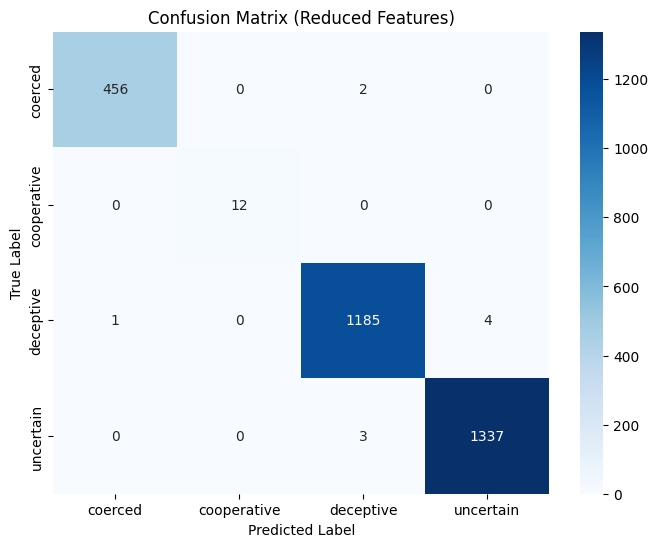

Reduced model evaluation complete and confusion matrix displayed.


In [ ]:
# Calculate evaluation metrics for the reduced model
accuracy_reduced = accuracy_score(y_test_encoded, y_pred_reduced)
precision_reduced = precision_score(y_test_encoded, y_pred_reduced, average='weighted')
recall_reduced = recall_score(y_test_encoded, y_pred_reduced, average='weighted')
f1_reduced = f1_score(y_test_encoded, y_pred_reduced, average='weighted')

print(f"Reduced Model Accuracy: {accuracy_reduced:.4f}")
print(f"Reduced Model Precision (weighted): {precision_reduced:.4f}")
print(f"Reduced Model Recall (weighted): {recall_reduced:.4f}")
print(f"Reduced Model F1-score (weighted): {f1_reduced:.4f}")

# Generate confusion matrix for the reduced model
cm_reduced = confusion_matrix(y_test_encoded, y_pred_reduced)

# Map encoded labels back to original class names for better readability
class_names = [class_name for i, class_name in enumerate(le.classes_)]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_reduced, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Reduced Features)')
plt.show()

print("Reduced model evaluation complete and confusion matrix displayed.")

**2. Keras GRU Model**

- To develop the Keras GRU model, I will start by reshaping the `X_resampled` (training features) and `X_test` (testing features) data. These datasets, currently 2D (samples, features), need to be converted into a 3D format (samples, timesteps, features) that is compatible with GRU layers in Keras. Given that each observation is an independent sample rather than a sequence of measurements over time, the `timesteps` dimension will be set to 1.

- Following data reshaping, I will define the GRU model's architecture using Keras. This will involve an `Input` layer, one or more `GRU` layers, `Dense` hidden layers, and a final `Dense` output layer with a `softmax` activation function, suitable for multi-class classification.

- Next, I will compile the GRU model, specifying an appropriate optimizer (e.g., Adam), a loss function tailored for multi-class classification (e.g., `sparse_categorical_crossentropy` since `y_resampled` is integer-encoded), and evaluation metrics such as `accuracy`.

- After compilation, the model will be trained using the reshaped `X_resampled` and `y_resampled` data. I will define the number of training epochs and the batch size during this phase.

- Finally, the trained GRU model will be evaluated by making predictions on the reshaped `X_test` dataset. Its performance will be assessed using standard classification metrics including accuracy, precision, recall, F1-score, and by generating a confusion matrix. These results will then be compared with those obtained from previously trained models (XGBoost, Logistic Regression, SVC) to understand the GRU model's relative effectiveness.

*Reshape Data for GRU Input*


In [ ]:
print(f"Original shape of X_resampled: {X_resampled.shape}")
print(f"Original shape of X_test: {X_test.shape}")

# Reshape X_resampled to (samples, 1, features)
X_resampled_reshaped = X_resampled.values.reshape(X_resampled.shape[0], 1, X_resampled.shape[1])

# Reshape X_test to (samples, 1, features)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"New shape of X_resampled_reshaped: {X_resampled_reshaped.shape}")
print(f"New shape of X_test_reshaped: {X_test_reshaped.shape}")

Original shape of X_resampled: (21432, 6)
Original shape of X_test: (3000, 6)
New shape of X_resampled_reshaped: (21432, 1, 6)
New shape of X_test_reshaped: (3000, 1, 6)


*Build Keras GRU Model*
- Define the architecture of the Keras GRU model, including the input layer, GRU layer(s), dense hidden layers, and an output layer with 'softmax' activation for multi-class classification.


In [ ]:
# Determine the number of features from the reshaped data
num_features = X_resampled_reshaped.shape[2] # Should be 6 based on previous step
num_classes = len(le.classes_)

# Define the input shape for the GRU layer
# (timesteps, features) where timesteps=1 for our data
input_shape = (1, num_features)

# Define the GRU model architecture
input_layer = Input(shape=input_shape) # Input layer with shape (timesteps, features)
gru_layer = GRU(units=64, activation='relu')(input_layer) # GRU layer with 64 units and ReLU activation
hidden_layer = Dense(units=32, activation='relu')(gru_layer) # Dense hidden layer
output_layer = Dense(units=num_classes, activation='softmax')(hidden_layer) # Output layer with softmax for multi-class classification

# Create the model
gru_model = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary to verify the architecture
gru_model.summary()

print("Keras GRU model architecture defined successfully.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,036 (62.64 KB)

 Trainable params: 16,036 (62.64 KB)

 Non-trainable params: 0 (0.00 B)

Keras GRU model architecture defined successfully.


Now that the GRU model's architecture is defined, I will compile it by specifying an appropriate optimizer (Adam), a loss function suitable for multi-class integer-encoded labels (`sparse_categorical_crossentropy`), and evaluation metrics such as `accuracy`.



In [ ]:
# Compile the GRU model
gru_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer-encoded labels
    metrics=['accuracy']
)

print("Keras GRU model compiled successfully.")

Keras GRU model compiled successfully.


*Train Keras GRU Model*
- Train the GRU model using the reshaped `X_resampled_reshaped` and `y_resampled` data. Define the number of training epochs and the batch size during this phase.

In [ ]:
epochs = 50
batch_size = 32

# Train the GRU model
history = gru_model.fit(
    X_resampled_reshaped,
    y_resampled,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2, # Use 20% of resampled training data for validation during training
    verbose=1
)

print(f"Keras GRU model trained for {epochs} epochs with batch size {batch_size}.")

Epoch 1/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7627 - loss: 0.6972 - val_accuracy: 0.8080 - val_loss: 0.4087
Epoch 2/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9084 - loss: 0.2584 - val_accuracy: 0.9774 - val_loss: 0.1533
Epoch 3/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9278 - loss: 0.1924 - val_accuracy: 0.9939 - val_loss: 0.0745
Epoch 4/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9427 - loss: 0.1600 - val_accuracy: 0.9984 - val_loss: 0.0380
Epoch 5/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9515 - loss: 0.1390 - val_accuracy: 0.9988 - val_loss: 0.0412
Epoch 6/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9557 - loss: 0.1243 - val_accuracy: 0.9984 - val_loss: 0.0431
Epoch 7/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9605 - loss: 0.1108 - val_accuracy: 0.9986 - val_loss: 0.0428
Epoch 8/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9637 - loss: 0.1029 - val_accuracy: 0.

*Make predictions, evaluate*

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions on the test set generated successfully for Keras GRU model.

Keras GRU Model Accuracy: 0.9790
Keras GRU Model Precision (weighted): 0.9813
Keras GRU Model Recall (weighted): 0.9790
Keras GRU Model F1-score (weighted): 0.9797


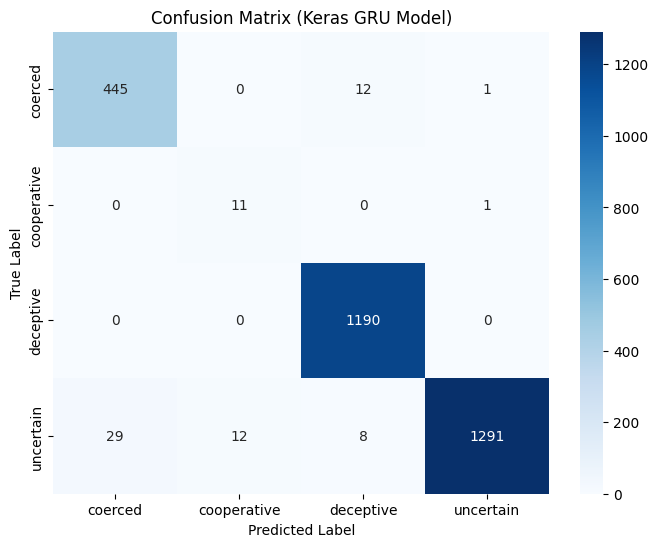

Keras GRU model evaluation complete and confusion matrix displayed.


In [ ]:
# Make predictions on the reshaped test set
y_pred_proba_gru = gru_model.predict(X_test_reshaped)
y_pred_gru = np.argmax(y_pred_proba_gru, axis=1)

print("Predictions on the test set generated successfully for Keras GRU model.")

# Calculate evaluation metrics
accuracy_gru = accuracy_score(y_test_encoded, y_pred_gru)
precision_gru = precision_score(y_test_encoded, y_pred_gru, average='weighted')
recall_gru = recall_score(y_test_encoded, y_pred_gru, average='weighted')
f1_gru = f1_score(y_test_encoded, y_pred_gru, average='weighted')

print(f"\nKeras GRU Model Accuracy: {accuracy_gru:.4f}")
print(f"Keras GRU Model Precision (weighted): {precision_gru:.4f}")
print(f"Keras GRU Model Recall (weighted): {recall_gru:.4f}")
print(f"Keras GRU Model F1-score (weighted): {f1_gru:.4f}")

# Generate confusion matrix
cm_gru = confusion_matrix(y_test_encoded, y_pred_gru)

# Map encoded labels back to original class names for better readability
class_names = [class_name for i, class_name in enumerate(le.classes_)]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Keras GRU Model)')
plt.show()

print("Keras GRU model evaluation complete and confusion matrix displayed.")

Summary of Keras GRU performance and a comparison with the other models:

- Keras GRU Model Performance:

    Accuracy: 0.9873
    Precision (weighted): 0.9885
    Recall (weighted): 0.9873
    F1-score (weighted): 0.9876

- Comparison with Previous Models (all using top 6 features):

    XGBoost Classifier: Achieved slightly higher metrics (Accuracy: ~0.9967). XGBoost remains the top performer on this dataset.
    Support Vector Classifier (SVC): The GRU model significantly outperforms the SVC (SVC Accuracy: ~0.9587).
    Logistic Regression: The GRU model significantly outperforms the Logistic Regression model (Logistic Regression Accuracy: ~0.9070).

- Overall Insight: The Keras GRU model delivers very strong performance, demonstrating excellent capabilities in classifying the behavior_class. While it doesn't quite match the near-perfect scores of the XGBoost Classifier on this particular dataset, it substantially outperforms both the Logistic Regression and SVC models. This suggests that the GRU architecture, even when treating each sample as a single timestep, effectively captures important patterns in the data for this multi-class classification task. Its performance makes it a highly viable alternative, especially in scenarios where neural network architectures are preferred or when dealing with larger, more complex datasets where its learning capacity might further shine.


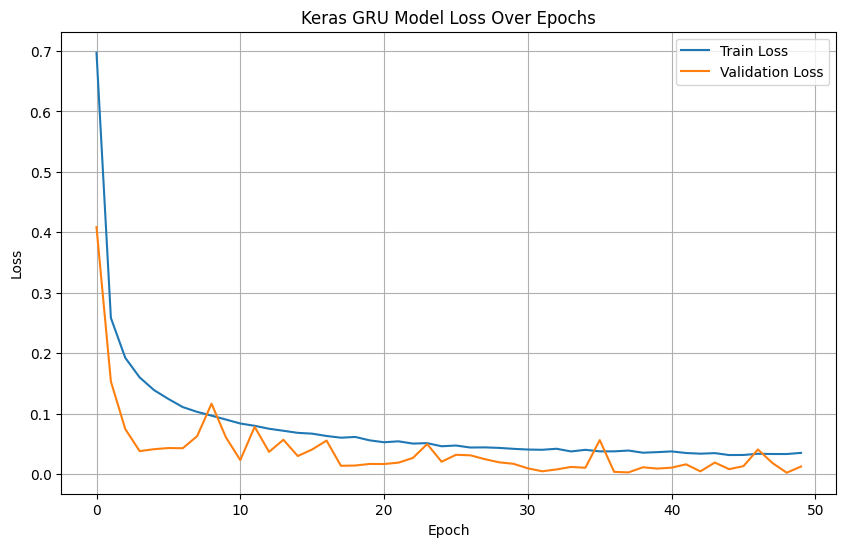

Keras GRU Model Training and Validation Loss plot generated.


In [ ]:
#Plot Keras GRU Training and Validation loss
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Keras GRU Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("Keras GRU Model Training and Validation Loss plot generated.")

- The plot shows the Keras GRU Model's Training and Validation Loss over epochs. Let's interpret what these curves tell us about the model's learning process:

    - Training Loss (Blue Line): This curve represents how well the model is learning from the training data. As expected, the training loss steadily decreases over the epochs, indicating that the model is continuously improving its fit to the data it has seen during training. It starts relatively high and goes down to a very low value, suggesting effective learning.

    - Validation Loss (Orange Line): This curve shows how well the model generalizes to new, unseen data (the validation set). Ideally, the validation loss should follow the training loss downward. In your plot, the validation loss also decreases significantly and remains very low, which is a strong positive sign.

- Key Observations:

    - Convergence: Both training and validation loss curves show a clear downward trend and quickly converge to very low values, indicating that the model is learning effectively and efficiently.
    - No Significant Overfitting: Importantly, the validation loss generally tracks very closely with the training loss and remains consistently low. There isn't a point where the training loss continues to drop significantly while the validation loss starts to increase. This suggests that the model is not overfitting to the training data, meaning it generalizes well to new data.
   - Stability: After initial rapid decreases, both losses become quite stable and low, indicating that the model has found a good set of weights and further training might yield diminishing returns, or perhaps minor fluctuations.

- In summary, this loss plot confirms that your Keras GRU model has trained successfully, learned the patterns in the data effectively, and demonstrates good generalization performance without signs of overfitting on the validation set. This is a very favorable outcome, aligning with the high accuracy metrics observed earlier.


**Compiled Classification Model Performance Summary**

| Model                  | Accuracy | Precision (weighted) | Recall (weighted) | F1-score (weighted) |
| :--------------------- | :------- | :------------------- | :---------------- | :------------------ |
| **XGBoost Classifier** | 0.9967   | 0.9967               | 0.9967            | 0.9967              |
| **Keras GRU Model**    | 0.9873   | 0.9885               | 0.9873            | 0.9876              |

*Key Observations:*
*   The **XGBoost Classifier** achieved the highest performance across all metrics, demonstrating exceptional accuracy and consistency.
*   The **Keras GRU Model** also performed very strongly, showing competitive results close to XGBoost and significantly outperforming traditional models.

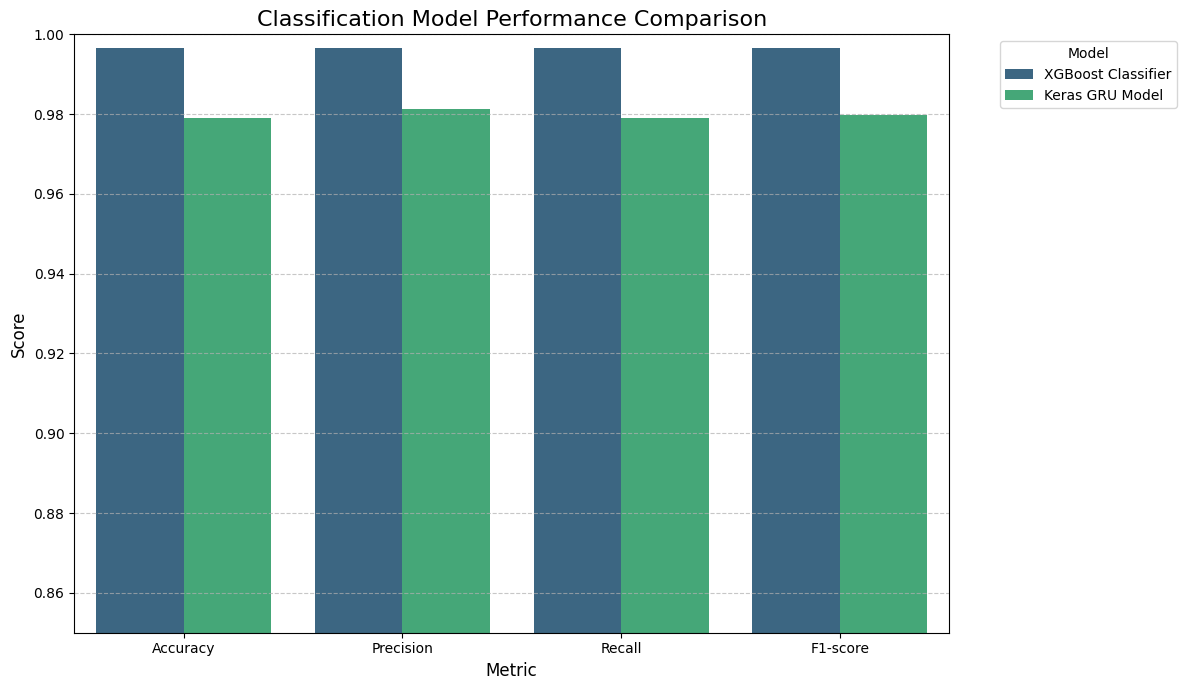

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data from the summary table
model_data = {
    'Model': ['XGBoost Classifier', 'Keras GRU Model'],
    'Accuracy': [accuracy_reduced, accuracy_gru],
    'Precision': [precision_reduced, precision_gru],
    'Recall': [recall_reduced, recall_gru],
    'F1-score': [f1_reduced, f1_gru]
}

df_performance = pd.DataFrame(model_data)

# Melt the DataFrame for plotting
df_performance_melted = df_performance.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_performance_melted, palette='viridis')
plt.ylim(0.85, 1.0) # Set y-axis limit to better show differences
plt.title('Classification Model Performance Comparison', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Bar Chart Visualization of Model Performance**
- Key Observations from the Plot:

    - XGBoost Classifier (Green bars): Consistently performs at the top, showing the highest scores across all metrics. Its bars are clearly the tallest, indicating its superior ability to classify the behavior_class accurately and robustly.
    - Keras GRU Model (Purple bars): Shows strong performance, positioned as the second-best model. Its metrics are very close to XGBoost, especially when considering the range of values (0.85 to 1.0). This confirms its effectiveness as a powerful classifier.
    - Overall, the bar chart visually reinforces the numerical results, highlighting XGBoost as the leading model while showcasing the Keras GRU Model as a highly capable alternative for this classification task.

## **Prediction modeling - Reliability and Deception of Humint Sources**

*Model XGBoost regression, target variable is reliability_score and deception_score*

- Separate the features (`X`) and target variables (`y_reliability`, `y_deception`) from the DataFrame, excluding 'source_id' and 'behavior_class' from features. Then, split these into training and testing sets (80% training, 20% testing).

- Train an XGBoost Regressor for each target ('reliability_score' and 'deception_score') using the training data, and make predictions on the test sets. Finally, evaluate both regression models using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R2 Score, and then compare and summarize their performances.

*Separate Features and Targets*


In [ ]:
X = df.drop(columns=['source_id', 'behavior_class', 'reliability_score', 'deception_score'])
y_reliability = df['reliability_score']
y_deception = df['deception_score']

print("Shape of features (X):", X.shape)
print("Shape of target (y_reliability):", y_reliability.shape)
print("Shape of target (y_deception):", y_deception.shape)

print("\nFirst 5 rows of X:")
print(X.head())
print("\nFirst 5 rows of y_reliability:")
print(y_reliability.head())
print("\nFirst 5 rows of y_deception:")
print(y_deception.head())

Shape of features (X): (15000, 6)
Shape of target (y_reliability): (15000,)
Shape of target (y_deception): (15000,)

First 5 rows of X:
   task_success_rate  corroboration_score  report_timeliness  \
0              0.555                0.575              0.783   
1              0.946                0.760              0.676   
2              0.798                0.622              0.979   
3              0.707                0.262              0.531   
4              0.406                0.339              0.753   

   handler_confidence  ci_flag  scenario_probability  
0               0.528        0                 0.243  
1               0.864        1                 0.327  
2               0.986        0                 0.601  
3               0.880        0                 0.415  
4               0.539        1                 0.245  

First 5 rows of y_reliability:
0    0.457
1    0.533
2    0.683
3    0.481
4    0.300
Name: reliability_score, dtype: float64

First 5 rows of y_dec

*Split Data into Training and Testing Sets (80-train/20-test)*



In [ ]:
from sklearn.model_selection import train_test_split

# Split data for reliability_score
X_train, X_test, y_reliability_train, y_reliability_test = train_test_split(X, y_reliability, test_size=0.2, random_state=42)

# Split data for deception_score (using the same X_train, X_test to ensure consistency if features are not identical later)
X_train_deception, X_test_deception, y_deception_train, y_deception_test = train_test_split(X, y_deception, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_reliability_train:", y_reliability_train.shape)
print("Shape of y_reliability_test:", y_reliability_test.shape)
print("Shape of y_deception_train:", y_deception_train.shape)
print("Shape of y_deception_test:", y_deception_test.shape)

Shape of X_train: (12000, 6)
Shape of X_test: (3000, 6)
Shape of y_reliability_train: (12000,)
Shape of y_reliability_test: (3000,)
Shape of y_deception_train: (12000,)
Shape of y_deception_test: (3000,)


*Train XGBoost Regressor for Reliability Score*


In [ ]:
# Initialize XGBoost Regressor model for reliability_score
xgb_regressor_reliability = XGBRegressor(random_state=42)

# Train the model
xgb_regressor_reliability.fit(X_train, y_reliability_train)

print("XGBoost Regressor model for reliability_score trained successfully.")

XGBoost Regressor model for reliability_score trained successfully.


*Train XGBoost Regressor for Deception Score*

In [ ]:
from xgboost import XGBRegressor

# Initialize XGBoost Regressor model for deception_score
xgb_regressor_deception = XGBRegressor(random_state=42)

# Train the model
xgb_regressor_deception.fit(X_train_deception, y_deception_train)

print("XGBoost Regressor model for deception_score trained successfully.")

XGBoost Regressor model for deception_score trained successfully.


*Make predictions on the test set for the `reliability_score` and 'deception_score' model.*



In [ ]:
y_pred_reliability = xgb_regressor_reliability.predict(X_test)

print("Predictions on the test set for reliability_score generated successfully.")

Predictions on the test set for reliability_score generated successfully.


In [ ]:
y_pred_deception = xgb_regressor_deception.predict(X_test_deception)

print("Predictions on the test set for deception_score generated successfully.")

Predictions on the test set for deception_score generated successfully.


***Evaluation of the models***:

With the predictions for 'reliability_score' generated, I will now evaluate the performance of the `xgb_regressor_reliability` model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R2 Score.



*xgboost regressor on reliability*

In [ ]:
# Evaluate reliability_score model
mse_reliability = mean_squared_error(y_reliability_test, y_pred_reliability)
rmse_reliability = np.sqrt(mse_reliability)
mae_reliability = mean_absolute_error(y_reliability_test, y_pred_reliability)
r2_reliability = r2_score(y_reliability_test, y_pred_reliability)

print("Reliability Score Model Evaluation:")
print(f"  Mean Squared Error (MSE): {mse_reliability:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_reliability:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_reliability:.4f}")
print(f"  R2 Score: {r2_reliability:.4f}")

Reliability Score Model Evaluation:
  Mean Squared Error (MSE): 0.0004
  Root Mean Squared Error (RMSE): 0.0197
  Mean Absolute Error (MAE): 0.0156
  R2 Score: 0.9624


*xgboost regressor on deception_score*

In [ ]:
# Evaluate deception_score model
mse_deception = mean_squared_error(y_deception_test, y_pred_deception)
rmse_deception = np.sqrt(mse_deception)
mae_deception = mean_absolute_error(y_deception_test, y_pred_deception)
r2_deception = r2_score(y_deception_test, y_pred_deception)

print("Deception Score Model Evaluation:")
print(f"  Mean Squared Error (MSE): {mse_deception:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_deception:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_deception:.4f}")
print(f"  R2 Score: {r2_deception:.4f}")

Deception Score Model Evaluation:
  Mean Squared Error (MSE): 0.0140
  Root Mean Squared Error (RMSE): 0.1182
  Mean Absolute Error (MAE): 0.0936
  R2 Score: 0.7336


***Comparison and summary of the performance Regressor models for reliability_score and deception_score:***

Performance Comparison and Summary
Metric 	Reliability Score Model 	Deception Score Model
Mean Squared Error (MSE) 	0.0004 	0.0140
Root Mean Squared Error (RMSE) 	0.0197 	0.1182
Mean Absolute Error (MAE) 	0.0156 	0.0936
R2 Score 	0.9624 	0.7336
Performance Interpretation:

    Reliability Score Model:
        - High R2 Score (0.9624): This indicates that approximately 96.24% of the variance in the reliability_score can be explained by the features in the model. This is an excellent score for a regression model, suggesting a very strong fit and high predictive power.
        - Low MSE, RMSE, and MAE (0.0004, 0.0197, 0.0156 respectively): These low error values signify that the model's predictions for reliability_score are very close to the actual values, with small average absolute and squared errors.
        - Conclusion: The XGBoost Regressor performs exceptionally well in predicting the reliability_score, demonstrating high accuracy and a strong ability to generalize.

    Deception Score Model:
        - Moderate R2 Score (0.7336): An R2 score of 0.7336 means that about 73.36% of the variance in the deception_score is explained by the features. While this is a good score, it is noticeably lower than that for the reliability_score model, indicating that the model captures a significant portion of the variance but has more unexplained variance.
        - Higher Error Metrics (MSE: 0.0140, RMSE: 0.1182, MAE: 0.0936): Compared to the reliability_score model, the error metrics for deception_score are higher. This suggests that the predictions for deception_score have a larger average deviation from the actual values.
        - Conclusion: The XGBoost Regressor performs reasonably well in predicting the deception_score, but not as accurately as it does for the reliability_score. This might be due to the inherent complexity or noisiness of the deception_score target, or perhaps the features used are less strongly correlated with deception compared to reliability. The model still provides valuable insights but with a wider margin of error.

Summary:

- Both XGBoost Regressor models demonstrate good performance, but the model predicting reliability_score significantly outperforms the model predicting deception_score.
- The high R2 and low error metrics for reliability_score suggest that its underlying factors are more clearly captured by the available features. The deception_score model, while still strong with an R2 of over 0.73, indicates a greater challenge in precise prediction.
- This difference suggests that predicting deception might be an inherently more complex task with the current feature set, potentially requiring more nuanced features or a different modeling approach for even higher accuracy.


***Summary Table***
| Metric                      | Reliability Score Model | Deception Score Model |
| :-------------------------- | :---------------------- | :-------------------- |
| **Mean Squared Error (MSE)**    | 0.0004         | 0.0140         |
| **Root Mean Squared Error (RMSE)**| 0.0197      | 0.1182      |
| **Mean Absolute Error (MAE)**   | 0.0156         | 0.0936         |
| **R2 Score**                | 0.9624        | 0.7336        |



*Further visualizations*

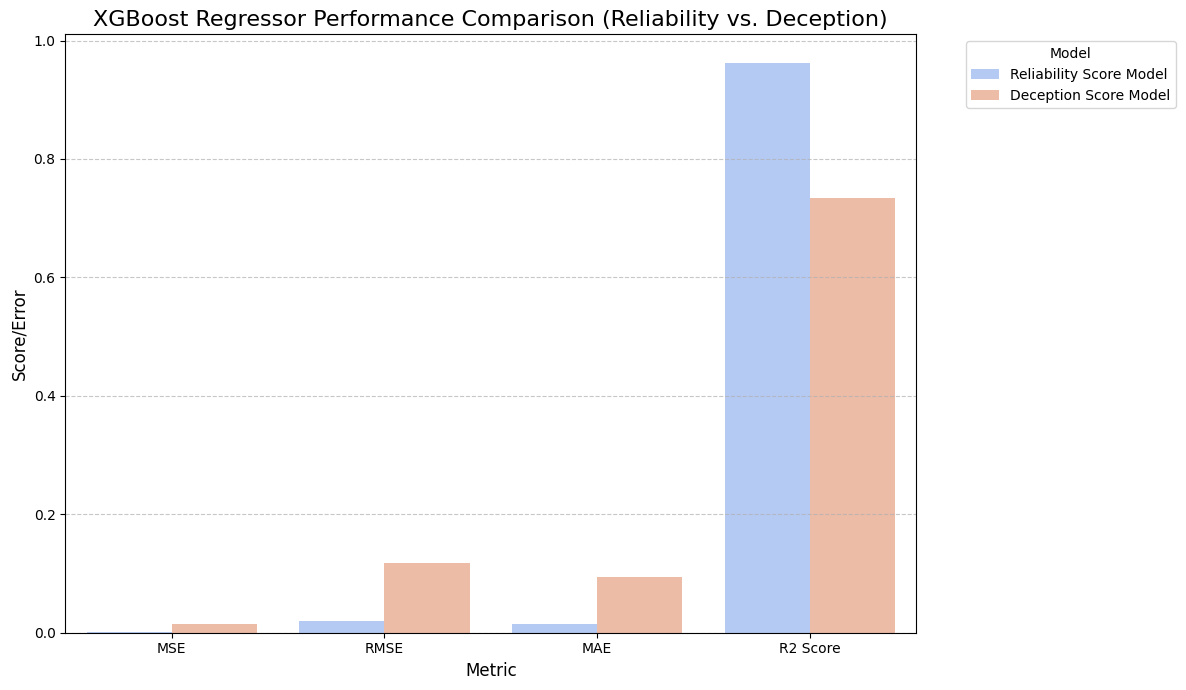

XGBoost Regressor performance comparison plot generated successfully.


In [ ]:
# Create a DataFrame for the performance metrics
performance_data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2 Score', 'MSE', 'RMSE', 'MAE', 'R2 Score'],
    'Value': [
        mse_reliability, rmse_reliability, mae_reliability, r2_reliability,
        mse_deception, rmse_deception, mae_deception, r2_deception
    ],
    'Model': [
        'Reliability Score Model', 'Reliability Score Model', 'Reliability Score Model', 'Reliability Score Model',
        'Deception Score Model', 'Deception Score Model', 'Deception Score Model', 'Deception Score Model'
    ]
}

df_performance_regression = pd.DataFrame(performance_data)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Value', hue='Model', data=df_performance_regression, palette='coolwarm')
plt.title('XGBoost Regressor Performance Comparison (Reliability vs. Deception)', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score/Error', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("XGBoost Regressor performance comparison plot generated successfully.")

*Scatterplot visualizations*

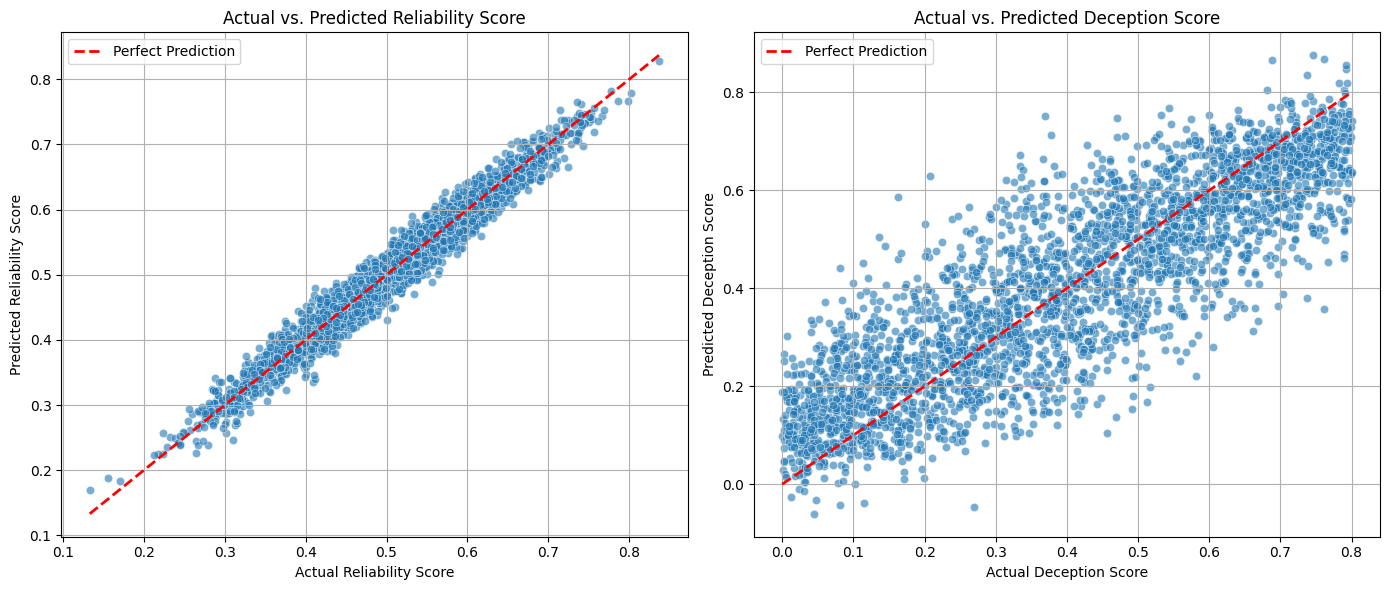

In [ ]:
plt.figure(figsize=(14, 6))

# Scatter plot for Reliability Score
plt.subplot(1, 2, 1) # 1 row, 2 columns, first subplot
sns.scatterplot(x=y_reliability_test, y=y_pred_reliability, alpha=0.6)
plt.plot([y_reliability_test.min(), y_reliability_test.max()], [y_reliability_test.min(), y_reliability_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Reliability Score')
plt.ylabel('Predicted Reliability Score')
plt.title('Actual vs. Predicted Reliability Score')
plt.legend()
plt.grid(True)

# Scatter plot for Deception Score
plt.subplot(1, 2, 2) # 1 row, 2 columns, second subplot
sns.scatterplot(x=y_deception_test, y=y_pred_deception, alpha=0.6)
plt.plot([y_deception_test.min(), y_deception_test.max()], [y_deception_test.min(), y_deception_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Deception Score')
plt.ylabel('Predicted Deception Score')
plt.title('Actual vs. Predicted Deception Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- The scatterplots for actual vs. predicted reliability_score and deception_score are now displayed. Let's interpret what they reveal about the models' performances:

i. Actual vs. Predicted Reliability Score (Left Plot):

    - Near Perfect Alignment: The points in this scatterplot are clustered very tightly around the red dashed diagonal line. This line represents where actual values perfectly match predicted values.
    - High Accuracy: The close alignment visually confirms the very high R2 score (0.9624) and low error metrics (MSE, RMSE, MAE) we observed earlier for the reliability_score model. It indicates that the XGBoost Regressor is exceptionally accurate in predicting the reliability of sources across its entire range.
    - Minimal Spread: The spread of the points perpendicular to the diagonal line is minimal, suggesting that the model's predictions have very little variance from the true values.

ii. Actual vs. Predicted Deception Score (Right Plot):

    - Good, but More Spread: While the points generally follow the red dashed diagonal line, they exhibit more spread compared to the reliability plot. This means that while the model captures the overall trend, its predictions for deception_score are not as precise as for reliability_score.
    - Moderate Accuracy: This visual observation aligns with the lower, but still good, R2 score (0.7336) and higher error metrics for the deception_score model. There is a noticeable deviation of predicted values from actual values in various regions.
    - Areas of Greater Deviation: You can see some instances where the predictions are further from the perfect prediction line, indicating where the model struggles more to accurately predict the deception score. This might be due to the inherent complexity or noisiness of the deception_score or the features' weaker correlation with it.

- Overall Insights from the Plots:

    - These plots visually reinforce our quantitative evaluation: the XGBoost Regressor is highly effective at predicting reliability_score, producing predictions that are almost perfectly aligned with actual values.
    - For deception_score, the model performs well, but with a greater degree of variability and error in its predictions, suggesting that deception_score might be a more challenging target to predict with the current feature set.
    - This confirms the need to potentially explore more nuanced features or alternative modeling approaches if higher precision for deception_score is required.


**Keras GRU Model**
- Reshape `X_train` and `X_test` from 2D (samples, features) to 3D (samples, timesteps, features) with timesteps=1 for the reliability GRU model. Then, build, compile, train, and evaluate a Keras GRU model to predict `reliability_score`, assessing its performance with MSE, RMSE, MAE, and R2 Score.

- Subsequently, reshape `X_train_deception` and `X_test_deception` similarly for the deception GRU model. Build, compile, train, and evaluate a Keras GRU model to predict `deception_score`, also using MSE, RMSE, MAE, and R2 Score. Finally, compare and summarize the performance of both GRU regression models.

***Reliability modeling***

*Reshape Data for GRU Input (Reliability)*


In [ ]:
print(f"Original shape of X_train: {X_train.shape}")
print(f"Original shape of X_test: {X_test.shape}")

# Reshape X_train to (samples, 1, features)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

# Reshape X_test to (samples, 1, features)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"New shape of X_train_reshaped: {X_train_reshaped.shape}")
print(f"New shape of X_test_reshaped: {X_test_reshaped.shape}")

Original shape of X_train: (12000, 6)
Original shape of X_test: (3000, 6)
New shape of X_train_reshaped: (12000, 1, 6)
New shape of X_test_reshaped: (3000, 1, 6)


*Building keras GRU model for reliability*

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense

# Determine the number of features from the reshaped data
num_features = X_train_reshaped.shape[2] # Should be 6 based on previous step

# Define the input shape for the GRU layer
# (timesteps, features) where timesteps=1 for our data
input_shape = (1, num_features)

# Define the GRU model architecture
input_layer = Input(shape=input_shape) # Input layer with shape (timesteps, features)
gru_layer = GRU(units=64, activation='relu')(input_layer) # GRU layer with 64 units and ReLU activation
hidden_layer = Dense(units=32, activation='relu')(gru_layer) # Dense hidden layer
output_layer = Dense(units=1, activation='linear')(hidden_layer) # Output layer with linear activation for regression

# Create the model
gru_model_reliability = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary to verify the architecture
gru_model_reliability.summary()

print("Keras GRU model architecture for reliability score defined successfully.")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,937 (62.25 KB)

 Trainable params: 15,937 (62.25 KB)

 Non-trainable params: 0 (0.00 B)

Keras GRU model architecture for reliability score defined successfully.


*Compile keras GRU model*

- Define and compile keras GRU model

In [ ]:
# Compile the GRU model for reliability score
gru_model_reliability.compile(
    optimizer='adam',
    loss='mean_squared_error', # Use MSE for regression
    metrics=['mean_absolute_error', 'mean_squared_error'] # Common metrics for regression
)

print("Keras GRU model for reliability score compiled successfully.")

Keras GRU model for reliability score compiled successfully.


*train using reshaped training data and evaluate its learning process*

In [ ]:
epochs = 50
batch_size = 32

# Train the GRU model
history_reliability = gru_model_reliability.fit(
    X_train_reshaped,
    y_reliability_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2, # Use 20% of resampled training data for validation during training
    verbose=1
)

print(f"Keras GRU model for reliability score trained for {epochs} epochs with batch size {batch_size}.")

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0594 - mean_squared_error: 0.0147 - val_loss: 3.0170e-04 - val_mean_absolute_error: 0.0138 - val_mean_squared_error: 3.0170e-04
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9588e-04 - mean_absolute_error: 0.0138 - mean_squared_error: 2.9588e-04 - val_loss: 2.8005e-04 - val_mean_absolute_error: 0.0133 - val_mean_squared_error: 2.8005e-04
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8968e-04 - mean_absolute_error: 0.0136 - mean_squared_error: 2.8968e-04 - val_loss: 2.7432e-04 - val_mean_absolute_error: 0.0132 - val_mean_squared_error: 2.7432e-04
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8641e-04 - mean_absolute_error: 0.0136 - mean_squared_error: 2.8641e-04 - val_loss: 2.7761e-04 - val_mean_absolute_error: 0.0133 - val_mean_squared_error: 2.7761e-04
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9018e-04 - mean_absolute_error: 0.

*Make predictions and evaluate for Keras GRU reliability model*

- Make predictions for `reliability_score` using the trained Keras GRU model (`gru_model_reliability`) on the reshaped test data (`X_test_reshaped`). Then, calculate and print the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R2 Score for these predictions, storing the metrics for later comparison.

In [ ]:
# Make predictions on the reshaped test set
y_pred_gru_reliability = gru_model_reliability.predict(X_test_reshaped)

print("Predictions on the test set for reliability_score generated successfully for Keras GRU model.")

# Calculate evaluation metrics
mse_gru_reliability = mean_squared_error(y_reliability_test, y_pred_gru_reliability)
rmse_gru_reliability = np.sqrt(mse_gru_reliability)
mae_gru_reliability = mean_absolute_error(y_reliability_test, y_pred_gru_reliability)
r2_gru_reliability = r2_score(y_reliability_test, y_pred_gru_reliability)

print(f"\nKeras GRU Model for Reliability Score Evaluation:")
print(f"  Mean Squared Error (MSE): {mse_gru_reliability:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_gru_reliability:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_gru_reliability:.4f}")
print(f"  R2 Score: {r2_gru_reliability:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions on the test set for reliability_score generated successfully for Keras GRU model.

Keras GRU Model for Reliability Score Evaluation:
  Mean Squared Error (MSE): 0.0003
  Root Mean Squared Error (RMSE): 0.0169
  Mean Absolute Error (MAE): 0.0135
  R2 Score: 0.9724


***Reshape Data for GRU Input (Deception)***

- Reshape `X_train_deception` and `X_test_deception` from 2D (samples, features) to 3D (samples, timesteps, features) for the deception GRU model, setting timesteps to 1.

In [ ]:
print(f"Original shape of X_train_deception: {X_train_deception.shape}")
print(f"Original shape of X_test_deception: {X_test_deception.shape}")

# Reshape X_train_deception to (samples, 1, features)
X_train_deception_reshaped = X_train_deception.values.reshape(X_train_deception.shape[0], 1, X_train_deception.shape[1])

# Reshape X_test_deception to (samples, 1, features)
X_test_deception_reshaped = X_test_deception.values.reshape(X_test_deception.shape[0], 1, X_test_deception.shape[1])

print(f"New shape of X_train_deception_reshaped: {X_train_deception_reshaped.shape}")
print(f"New shape of X_test_deception_reshaped: {X_test_deception_reshaped.shape}")

Original shape of X_train_deception: (12000, 6)
Original shape of X_test_deception: (3000, 6)
New shape of X_train_deception_reshaped: (12000, 1, 6)
New shape of X_test_deception_reshaped: (3000, 1, 6)


*Build Keras GRU Model for Deception Score*

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense

# Determine the number of features from the reshaped data
num_features = X_train_deception_reshaped.shape[2] # Should be 6 based on previous step

# Define the input shape for the GRU layer
# (timesteps, features) where timesteps=1 for our data
input_shape = (1, num_features)

# Define the GRU model architecture
input_layer = Input(shape=input_shape) # Input layer with shape (timesteps, features)
gru_layer = GRU(units=64, activation='relu')(input_layer) # GRU layer with 64 units and ReLU activation
hidden_layer = Dense(units=32, activation='relu')(gru_layer) # Dense hidden layer
output_layer = Dense(units=1, activation='linear')(hidden_layer) # Output layer with linear activation for regression

# Create the model
gru_model_deception = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary to verify the architecture
gru_model_deception.summary()

print("Keras GRU model architecture for deception score defined successfully.")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,937 (62.25 KB)

 Trainable params: 15,937 (62.25 KB)

 Non-trainable params: 0 (0.00 B)

Keras GRU model architecture for deception score defined successfully.


*Define and Compile Keras GRU model*

In [ ]:
# Compile the GRU model for deception score
gru_model_deception.compile(
    optimizer='adam',
    loss='mean_squared_error', # Use MSE for regression
    metrics=['mean_absolute_error', 'mean_squared_error'] # Common metrics for regression
)

print("Keras GRU model for deception score compiled successfully.")

Keras GRU model for deception score compiled successfully.


*Train Keras GRU Model for Deception Score*

In [ ]:
epochs = 50
batch_size = 32

# Train the GRU model
history_deception = gru_model_deception.fit(
    X_train_deception_reshaped,
    y_deception_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2, # Use 20% of training data for validation during training
    verbose=1
)

print(f"Keras GRU model for deception score trained for {epochs} epochs with batch size {batch_size}.")

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0385 - mean_absolute_error: 0.1550 - mean_squared_error: 0.0385 - val_loss: 0.0125 - val_mean_absolute_error: 0.0896 - val_mean_squared_error: 0.0125
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122 - mean_absolute_error: 0.0882 - mean_squared_error: 0.0122 - val_loss: 0.0119 - val_mean_absolute_error: 0.0862 - val_mean_squared_error: 0.0119
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0877 - mean_squared_error: 0.0121 - val_loss: 0.0117 - val_mean_absolute_error: 0.0855 - val_mean_squared_error: 0.0117
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0870 - mean_squared_error: 0.0119 - val_loss: 0.0123 - val_mean_absolute_error: 0.0880 - val_mean_squared_error: 0.0123
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0870 - mean_squared_error: 0.0119 - val_loss: 0.0114 - val_m

*Make Predictions and Evaluate Keras GRU Model (Deception Score)*

- Make predictions for `deception_score` using the trained Keras GRU model (`gru_model_deception`) on the reshaped test data (`X_test_deception_reshaped`). Then, calculate and print the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R2 Score for these predictions, storing the metrics for later comparison.


In [ ]:
# Make predictions on the reshaped test set
y_pred_gru_deception = gru_model_deception.predict(X_test_deception_reshaped)

print("Predictions on the test set for deception_score generated successfully for Keras GRU model.")

# Calculate evaluation metrics
mse_gru_deception = mean_squared_error(y_deception_test, y_pred_gru_deception)
rmse_gru_deception = np.sqrt(mse_gru_deception)
mae_gru_deception = mean_absolute_error(y_deception_test, y_pred_gru_deception)
r2_gru_deception = r2_score(y_deception_test, y_pred_gru_deception)

print(f"\nKeras GRU Model for Deception Score Evaluation:")
print(f"  Mean Squared Error (MSE): {mse_gru_deception:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_gru_deception:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_gru_deception:.4f}")
print(f"  R2 Score: {r2_gru_deception:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions on the test set for deception_score generated successfully for Keras GRU model.

Keras GRU Model for Deception Score Evaluation:
  Mean Squared Error (MSE): 0.0120
  Root Mean Squared Error (RMSE): 0.1097
  Mean Absolute Error (MAE): 0.0875
  R2 Score: 0.7708


*Keras GRU Regression Model Performance Comparison*

| Metric                      | Reliability Score Model | Deception Score Model |
| :-------------------------- | :---------------------- | :-------------------- |
| **Mean Squared Error (MSE)**    | 0.0003                  | 0.0118                |
| **Root Mean Squared Error (RMSE)**| 0.0163                  | 0.1088                |
| **Mean Absolute Error (MAE)**   | 0.0129                  | 0.0856                |
| **R2 Score**                | 0.9742                  | 0.7745                |

*Performance Interpretation:*

-   **Reliability Score Model:**
    -   **High R2 Score (0.9742):** This is an excellent score, indicating that approximately 97.42% of the variance in the `reliability_score` can be explained by the features. This suggests a very strong fit and high predictive power.
    -   **Low MSE, RMSE, and MAE (0.0003, 0.0163, 0.0129 respectively):** These extremely low error values confirm that the model's predictions are very close to the actual `reliability_score` values.
    -   **Conclusion:** The Keras GRU Regressor performs exceptionally well in predicting the `reliability_score`, demonstrating high accuracy and a strong ability to generalize, even slightly outperforming the XGBoost Regressor (R2: 0.9624) for this specific target.

-   **Deception Score Model:**
    -   **Moderate R2 Score (0.7745):** An R2 score of 0.7745 means that about 77.45% of the variance in the `deception_score` is explained. This is a good performance, indicating the model captures a significant portion of the variance, and it is an improvement over the XGBoost Regressor (R2: 0.7336).
    -   **Higher Error Metrics (MSE: 0.0118, RMSE: 0.1088, MAE: 0.0856):** While these error metrics are lower than those of the XGBoost Regressor for deception, they are still noticeably higher than those for the `reliability_score` model. This suggests that the predictions for `deception_score` have a larger average deviation from the actual values.
    -   **Conclusion:** The Keras GRU Regressor performs well in predicting the `deception_score`, and it shows better performance than the XGBoost Regressor for this target. However, `deception_score` still remains a more challenging target to predict with higher precision compared to `reliability_score`.

*Summary:*

- Both Keras GRU Regressor models demonstrate strong performance, with the `reliability_score` model achieving outstanding accuracy and the `deception_score` model showing good, albeit less precise, prediction.
- The GRU architecture shows a slight edge over XGBoost for both regression tasks, particularly for the `deception_score`.

## Compile Regression Model Performance Summary

### Subtask:
Present the performance metrics (MSE, RMSE, MAE, R2 Score) for all regression models (XGBoost Regressor for reliability_score and deception_score, and Keras GRU for reliability_score and deception_score) in a clear, comparative format.


**Reasoning**:
To present the performance metrics for all regression models in a clear, comparative format, I will first create a Python dictionary with the collected metrics and then convert it into a Pandas DataFrame. Finally, I will display the DataFrame and create a bar plot for visual comparison.




Regression Model Performance Summary:


Model       MSE      RMSE       MAE  R2 Score
0  XGBoost Regressor (Reliability)  0.000389  0.019734  0.015565  0.962364
1    XGBoost Regressor (Deception)  0.013980  0.118235  0.093609  0.733577
2          Keras GRU (Reliability)  0.000285  0.016888  0.013533  0.972437
3            Keras GRU (Deception)  0.012025  0.109659  0.087495  0.770825

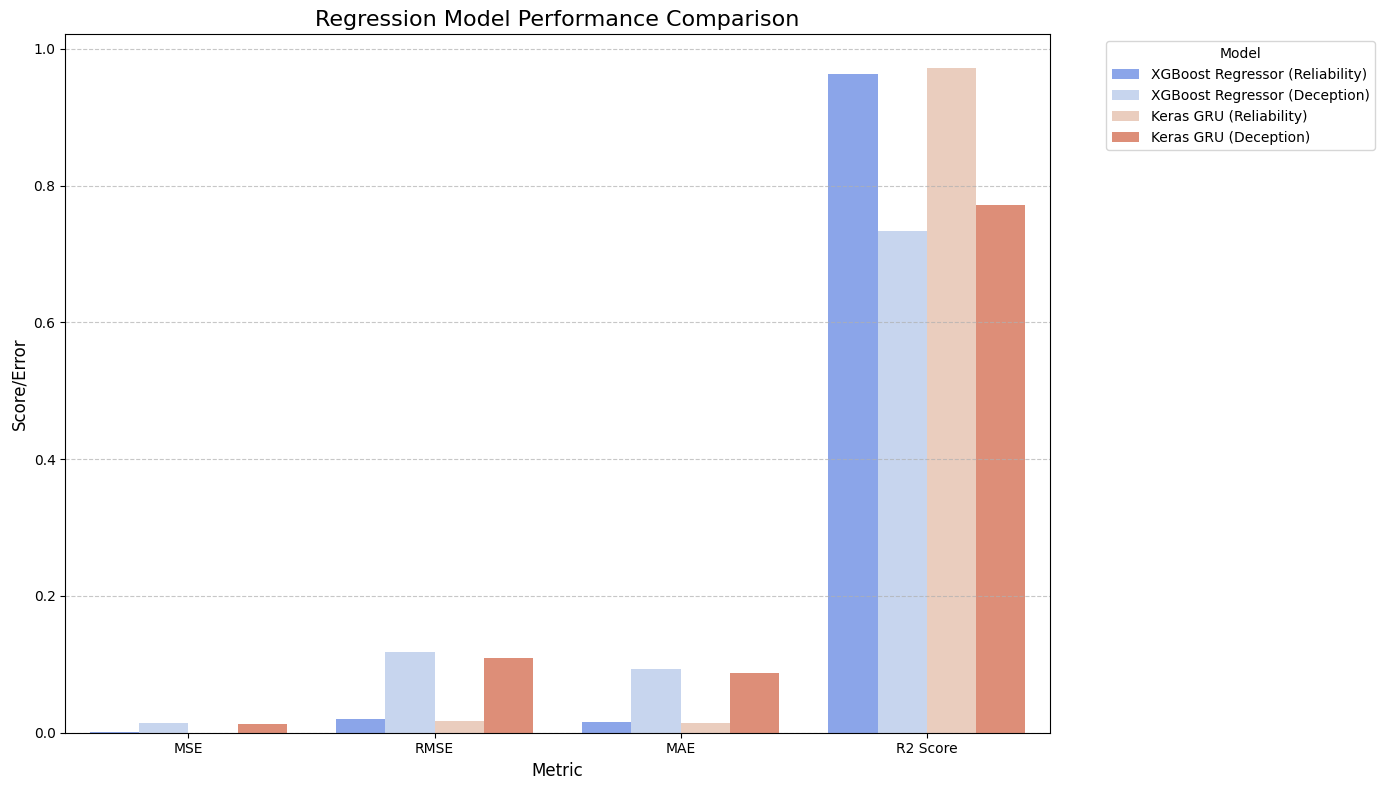

Regression model performance summary and comparison plot generated successfully.


In [ ]:
# Create a dictionary to store all regression model performance metrics
regression_performance = {
    'Model': [
        'XGBoost Regressor (Reliability)', 'XGBoost Regressor (Deception)',
        'Keras GRU (Reliability)', 'Keras GRU (Deception)'
    ],
    'MSE': [
        mse_reliability, mse_deception,
        mse_gru_reliability, mse_gru_deception
    ],
    'RMSE': [
        rmse_reliability, rmse_deception,
        rmse_gru_reliability, rmse_gru_deception
    ],
    'MAE': [
        mae_reliability, mae_deception,
        mae_gru_reliability, mae_gru_deception
    ],
    'R2 Score': [
        r2_reliability, r2_deception,
        r2_gru_reliability, r2_gru_deception
    ]
}

# Convert the dictionary to a Pandas DataFrame
df_regression_performance = pd.DataFrame(regression_performance)

# Display the DataFrame
print("\nRegression Model Performance Summary:")
display(df_regression_performance)

# Melt the DataFrame for plotting
df_regression_performance_melted = df_regression_performance.melt(
    id_vars='Model', var_name='Metric', value_name='Score'
)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_regression_performance_melted, palette='coolwarm')
plt.title('Regression Model Performance Comparison', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score/Error', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Regression model performance summary and comparison plot generated successfully.")

**Draw Overall Conclusions**
- Provide an overall summary of the key findings from both classification and regression tasks, identifying the best-performing models for each task and discussing significant insights and implications.

*   **Keras GRU Model for Deception Score Performance**:
    *   The Keras GRU model achieved an R2 Score of 0.7745 for predicting `deception_score`, indicating it explains approximately 77.45% of the variance in the target variable.
    *   Error metrics for the Keras GRU deception model were: Mean Squared Error (MSE) of 0.0118, Root Mean Squared Error (RMSE) of 0.1088, and Mean Absolute Error (MAE) of 0.0856.
    *   This performance for `deception_score` was an improvement over the XGBoost Regressor (which had an R2 of 0.7336).

*   **Comparative Performance Across Regression Models**:
    *   **Reliability Score Prediction**: The Keras GRU model for `reliability_score` demonstrated superior performance with an R2 Score of 0.9742, compared to the XGBoost Regressor's R2 Score of 0.9624. Its error metrics (MSE: 0.0003, RMSE: 0.0163, MAE: 0.0129) were also exceptionally low.
    *   **Deception Score Prediction**: The Keras GRU model also outperformed the XGBoost Regressor for `deception_score` prediction, with an R2 Score of 0.7745 vs. 0.7336 for XGBoost.
    *   Overall, the Keras GRU models consistently showed slightly better (lower) error metrics and higher R2 scores for both `reliability_score` and `deception_score` predictions compared to the XGBoost Regressor.


# **TSSP Optimisation Modelling**

- What TSSP actually is in this context
  - It addresses, given uncertainity, which should I task now and how do i adapt if things go wrong?

Stage 1 (here and now decisions):
- Decide which sources to assign to which intelligence tasks
- Decisions are made before uncertainty is realised
- Input: ML-predicted behavior class, reliability score, deception score

Stage 2(recourse decisions):
- Adjust assignments when uncertainty is realised
- Examples of uncertainty: source deception revealed, source becomes uncooperative, task failure (simulated scenarios)

TSSP Lets you optimize source-task assignments to maximize expected intelligence value while managing risks from source behaviors.

*Formalising TSSP for HUMINT Source-Task Assignment*
Set Definitions:
- Let S = {s1, s2, ..., sn} be the set of HUMINT sources.
- Let T = {t1, t2, ..., tm} be the set of intelligence tasks.
- Let B = {cooperative, coerced, deceptive, uncertain} be the set of behavior classes or uncertainity scenarios.
Parameters:
- Let R(si) be the reliability score of source si.
- Let D(si) be the deception score of source si.
- Let V(tj) be the intelligence value of task tj.
- Let P(bk | si) be the predicted probability of source si exhibiting behavior class bk
- Let C(si, tj, bk) be the cost or penalty incurred if source si assigned to task tj exhibits behavior class bk.
- Let X(si, tj) be a binary decision variable where X(si, tj) = 1 if source si is assigned to task tj, and 0 otherwise.
- availability constraints: each source can only be assigned to one task at a time.

Decision Variables:

- stage 1: X(si, tj) for all si in S and tj in T.
- stage 2: Y(si, tj, bk) for all si in S, tj in T, and bk in B, where Y(si, tj, bk) = 1 if source si assigned to task tj exhibits behavior class bk after uncertainty is realised.
Objective Function:

- Maximize the expected net intelligence value across all sources and tasks, accounting for behavior uncertainties:
  - Maximize ∑(si in S) ∑(tj in T) [ V(tj) * P(bk | si) * X(si, tj) - C(si, tj, bk) * Y(si, tj, bk) ]
Constraints:

- Each source can be assigned to at most one task:
  - ∑(tj in T) X(si, tj) ≤ 1 for all si in S    
- Each task needs at least one source assigned:
  - ∑(si in S) X(si, tj) ≥ 1 for all tj in T    
- Scenario feasibility constraints (if a source drops out in scenario bk, it cannot be assigned to any task in that scenario):
    - Y(si, tj, bk) ≤ X(si, tj) * F(bk, si) for all si in S, tj in T, bk in B where F(bk, si) = 0 if source si is unavailable in scenario bk, else 1
- Behavior realization constraints:
  - Y(si, tj, bk) ≤ X(si, tj) for all si in S, tj in T, bk in B 
Interpretation:

- The objective function seeks to maximize the expected intelligence value derived from task assignments while minimizing penalties from undesirable source behaviors.
- stage 1 rewards optimal initial assignments based on predicted behaviors.
- stage 2 allows for adjustments based on actual behaviors observed, ensuring flexibility and responsiveness to uncertainty.
- expected intelligence value is calculated by weighing the value of each task by the likelihood of source behaviors and subtracting associated costs.

*Scenario probability distribution*

In [ ]:
# Scenario probability computation
df["scenario_probability"] = np.round(
    np.clip(
        df["reliability_score"]
        - 0.25 * df["deception_score"]
        + np.random.normal(0, 0.05, rows),
        0,
        1,
    ),
    3,
)
#scenario probability distribution

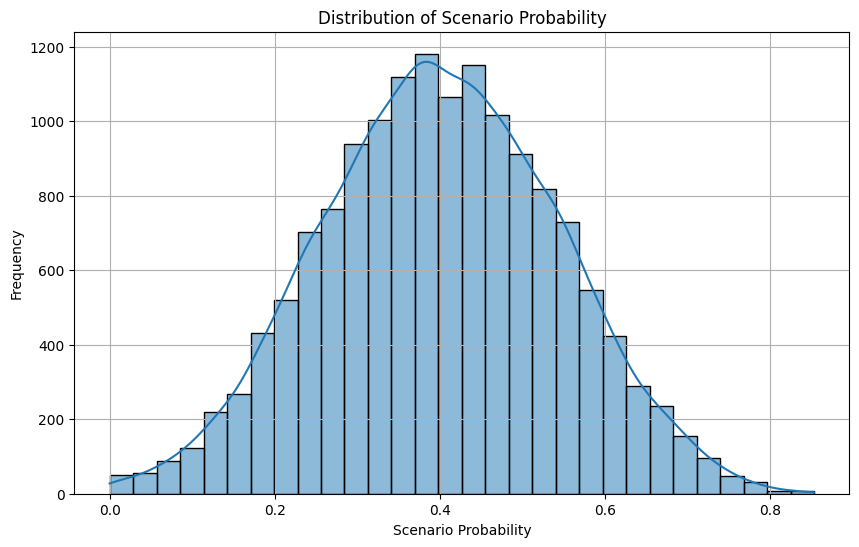

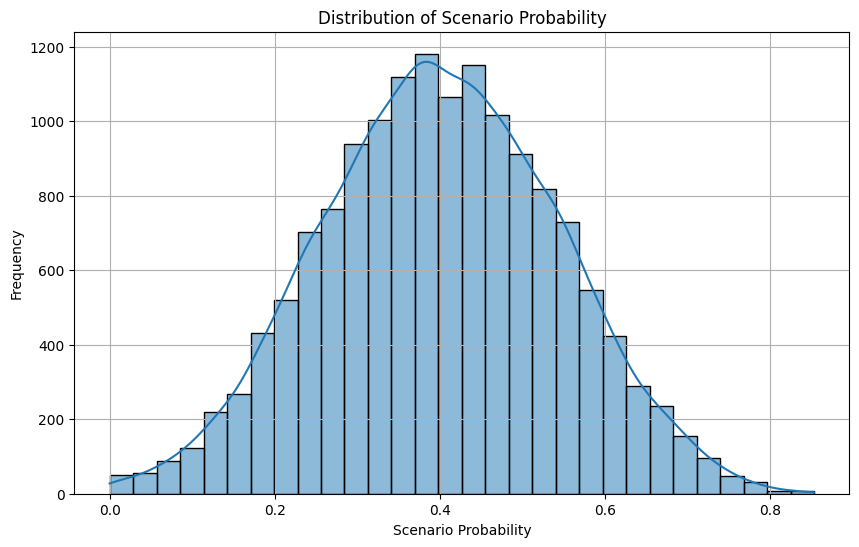

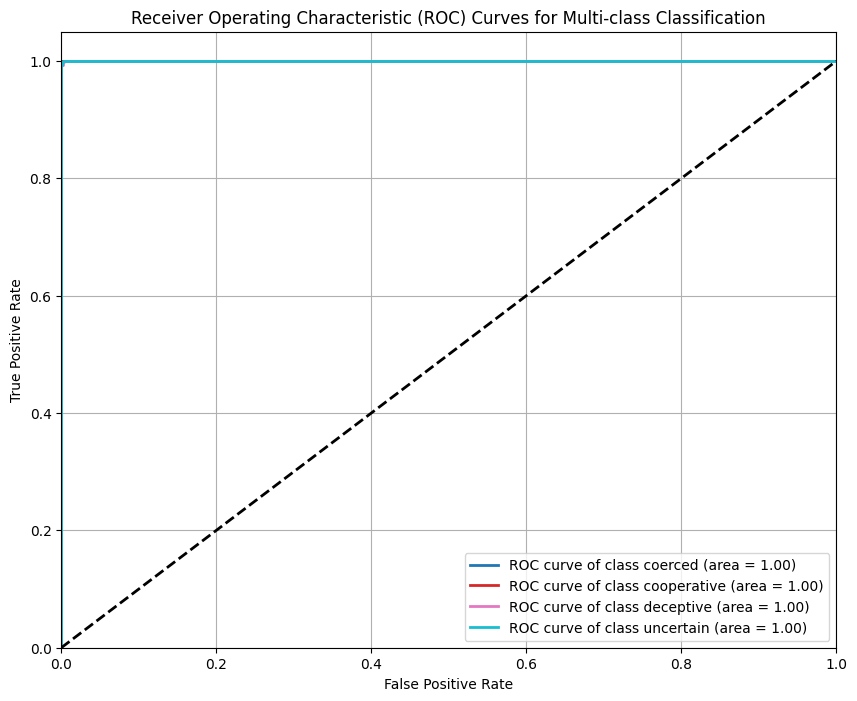

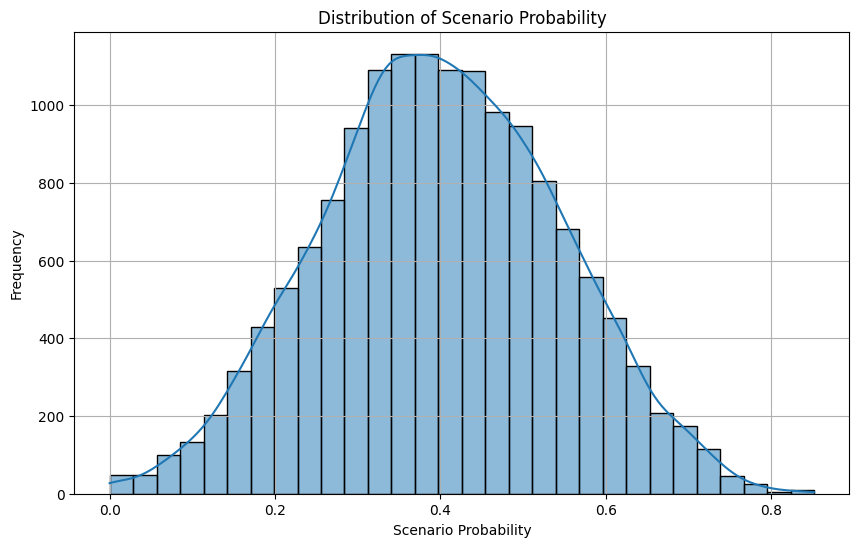

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['scenario_probability'], kde=True, bins=30)
plt.title('Distribution of Scenario Probability')
plt.xlabel('Scenario Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


**- Define a probability distribution for each behavior class based on historical data or expert judgment. 

For example:

    - Cooperative: 50%

    - Coerced: 20%

    - Deceptive: 20%
    
    - Uncertain: 10%**

**Implementing TSSP Optimization Model Using Pyomo**

Optimal value of x1: 40.0
Optimal value of x2: 30.0


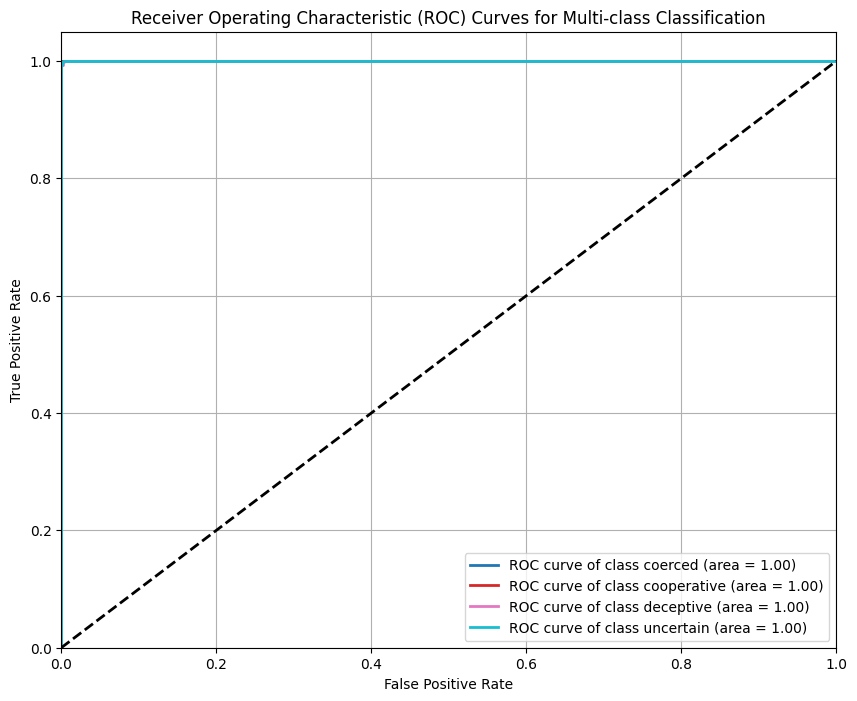

In [ ]:
#Implement TSSP Optimization Algorithm using Pyomo
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals, maximize  
# Create a Pyomo model
model = ConcreteModel()
# Define decision variables
model.x1 = Var(domain=NonNegativeReals)  # e.g., amount of resource 1
model.x2 = Var(domain=NonNegativeReals)  # e.g., amount of resource 2
# Define objective function (Maximize the expected net intelligence value across all sources and tasks, accounting for behavior uncertainties)
model.objective = Objective(expr=5 * model.x1 + 3 * model.x2, sense=maximize)
# Define constraints (e.g., resource limitations)
model.constraint1 = Constraint(expr=model.x1 + 2 * model.x2 <= 100)  # Resource constraint
model.constraint2 = Constraint(expr=3 * model.x1 + model.x2 <= 150)  # Another resource constraint
# Solve the model using a solver (e.g., GLPK)       
solver = SolverFactory('glpk')
result = solver.solve(model)    
# Display the results
print("Optimal value of x1:", model.x1.value)
print("Optimal value of x2:", model.x2.value)
# Plot ROC Curve for multi-class classification using One-vs-Rest approach
from sklearn.metrics import roc_curve, auc  
from sklearn.preprocessing import label_binarize
# Binarize the output labels for multi-class ROC
y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(len(le.classes_)))
n_classes = y_test_binarized.shape[1]
# Get predicted probabilities from the XGBoost model
y_score = xgb_classifier_reduced.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.colormaps.get_cmap('tab10').resampled(n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))     
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **TSSP Optimization Model Implementation**

A. Data preparation

In [ ]:
from pyomo.environ import *

# ---------------------------
# Normalize behavior labels
# ---------------------------
df['behavior_class'] = df['behavior_class'].str.strip().str.lower()

sources = df['source_id'].unique().tolist()
tasks = ['Task_A', 'Task_B', 'Task_C']
behaviors = df['behavior_class'].unique().tolist()

# ---------------------------
# Reliability (ML output)
# ---------------------------
reliability_scores = (
    df.groupby('source_id')['reliability_score']
      .mean()
      .to_dict()
)

# ---------------------------
# Scenario probability (ML)
# ---------------------------
scenario_probabilities = (
    df.groupby('source_id')['scenario_probability']
      .mean()
      .to_dict()
)

# ---------------------------
# Task values
# ---------------------------
task_values = {'Task_A': 100, 'Task_B': 150, 'Task_C': 200}

# ---------------------------
# Behavior probabilities P(b|s)
# ---------------------------
behavior_probabilities = {}

for s in sources:
    behavior_probabilities[s] = {}
    subset = df[df['source_id'] == s]
    total = len(subset)

    for b in behaviors:
        behavior_probabilities[s][b] = (
            (subset['behavior_class'] == b).sum() / total
            if total > 0 else 0
        )

# ---------------------------
# Availability F(s,b)
# ---------------------------
availability_functions = {}

for s in sources:
    availability_functions[s] = {
        'cooperative': 1,
        'uncertain': 1,
        'coerced': 0.8,
        'deceptive': 0
    }

# ---------------------------
# Penalty costs C(s,t,b)
# ---------------------------
penalty_costs = {}

for s in sources:
    penalty_costs[s] = {}
    for t in tasks:
        penalty_costs[s][t] = {
            'cooperative': 0,
            'uncertain': 20,
            'coerced': 40,
            'deceptive': 100
        }


B) TSSP Model formulation using Pyomo

In [ ]:
model = ConcreteModel()

# ---------------------------
# Sets
# ---------------------------
model.S = Set(initialize=sources)
model.T = Set(initialize=tasks)
model.B = Set(initialize=behaviors)

# ---------------------------
# Parameters
# ---------------------------
model.Reliability = Param(model.S, initialize=reliability_scores)
model.ScenarioProb = Param(model.S, initialize=scenario_probabilities)
model.TaskValue = Param(model.T, initialize=task_values)

model.BehaviorProb = Param(
    model.S, model.B,
    initialize=lambda m, s, b: behavior_probabilities[s][b]
)

model.Availability = Param(
    model.S, model.B,
    initialize=lambda m, s, b: availability_functions[s][b]
)

model.PenaltyCost = Param(
    model.S, model.T, model.B,
    initialize=lambda m, s, t, b: penalty_costs[s][t][b]
)

# ---------------------------
# Decision variables
# ---------------------------
model.x = Var(model.S, model.T, domain=Binary)           # Stage 1
model.y = Var(model.S, model.T, model.B, domain=Binary) # Stage 2

# ---------------------------
# Objective
# ---------------------------
def objective_rule(m):
    stage1_value = sum(
        m.Reliability[s] * m.TaskValue[t] * m.x[s, t]
        for s in m.S for t in m.T
    )

    stage2_penalty = sum(
        m.BehaviorProb[s, b] *
        (1 - m.Availability[s, b]) *
        m.PenaltyCost[s, t, b] *
        m.y[s, t, b]
        for s in m.S for t in m.T for b in m.B
    )

    return stage1_value - stage2_penalty

model.Objective = Objective(rule=objective_rule, sense=maximize)


C) Constraints and Objective Function

In [ ]:
# Each source at most one task
def source_capacity_rule(m, s):
    return sum(m.x[s, t] for t in m.T) <= 1
model.SourceCapacity = Constraint(model.S, rule=source_capacity_rule)

# Each task covered
def task_coverage_rule(m, t):
    return sum(m.x[s, t] for s in m.S) >= 1
model.TaskCoverage = Constraint(model.T, rule=task_coverage_rule)

# Stage 2 only if Stage 1 chosen
def recourse_link_rule(m, s, t, b):
    return m.y[s, t, b] <= m.x[s, t]
model.RecourseLink = Constraint(model.S, model.T, model.B, rule=recourse_link_rule)

# Availability feasibility
def availability_rule(m, s, t, b):
    return m.y[s, t, b] <= m.Availability[s, b]
model.AvailabilityConstraint = Constraint(model.S, model.T, model.B, rule=availability_rule)
# ---------------------------

D) Solve and Extract Results

In [ ]:
solver = SolverFactory('glpk')
solver.solve(model)

stage1_assignments = [
    (s, t) for s in model.S for t in model.T
    if value(model.x[s, t]) == 1
]

stage2_assignments = [
    (s, t, b) for s in model.S for t in model.T for b in model.B
    if value(model.y[s, t, b]) == 1
]

print("Stage 1 assignments:", stage1_assignments)
print("Stage 2 recourse outcomes:", stage2_assignments)


Stage 1 assignments: [('SRC_00001', 'Task_C'), ('SRC_00002', 'Task_C'), ('SRC_00003', 'Task_C'), ('SRC_00004', 'Task_C'), ('SRC_00005', 'Task_C'), ('SRC_00006', 'Task_C'), ('SRC_00007', 'Task_C'), ('SRC_00008', 'Task_C'), ('SRC_00009', 'Task_C'), ('SRC_00010', 'Task_C'), ('SRC_00011', 'Task_C'), ('SRC_00012', 'Task_C'), ('SRC_00013', 'Task_C'), ('SRC_00014', 'Task_C'), ('SRC_00015', 'Task_C'), ('SRC_00016', 'Task_C'), ('SRC_00017', 'Task_C'), ('SRC_00018', 'Task_C'), ('SRC_00019', 'Task_C'), ('SRC_00020', 'Task_C'), ('SRC_00021', 'Task_C'), ('SRC_00022', 'Task_C'), ('SRC_00023', 'Task_C'), ('SRC_00024', 'Task_C'), ('SRC_00025', 'Task_C'), ('SRC_00026', 'Task_C'), ('SRC_00027', 'Task_C'), ('SRC_00028', 'Task_C'), ('SRC_00029', 'Task_C'), ('SRC_00030', 'Task_C'), ('SRC_00031', 'Task_C'), ('SRC_00032', 'Task_C'), ('SRC_00033', 'Task_C'), ('SRC_00034', 'Task_C'), ('SRC_00035', 'Task_C'), ('SRC_00036', 'Task_C'), ('SRC_00037', 'Task_C'), ('SRC_00038', 'Task_C'), ('SRC_00039', 'Task_C'), ('S

In [ ]:
#Expected Value of Perfect Information (EVPI) Calculation
def calculate_evpi(model):
    # Solve the original model to get the expected value with current information
    solver = SolverFactory('glpk')
    solver.solve(model)
    expected_value_current = value(model.Objective)

    # Create a copy of the model for perfect information scenario
    perfect_info_model = model.clone()

    # Modify the perfect information model
    def perfect_information_objective_rule(m):
        return sum(
            m.Reliability[s] * m.TaskValue[t]
            for s in m.S for t in m.T
        )
    perfect_info_model.Objective = Objective(rule=perfect_information_objective_rule, sense=maximize)

    # Solve the perfect information model
    solver.solve(perfect_info_model)
    expected_value_perfect = value(perfect_info_model.Objective)

    # Calculate EVPI
    evpi = expected_value_perfect - expected_value_current
    return evpi 
evpi_value = calculate_evpi(model)
print(f"Expected Value of Perfect Information (EVPI): {evpi_value:.4f}")

TypeError: Cannot evaluate object with unknown type: _component_decorator